# Documentation

**Author:** Spencer Ressel

**Created:** June 14th, 2023

---

This code numerically solves the governing equations from Matsuno (1966). It was initially written by Daniel Lloveras as a project for the course ATM S 582.  The solver uses the pseudospectral method with leapfrog time differencing to solve the equations of motion.

---

# Imports

In [20]:
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
import sys
import time
import json
from glob import glob
import numpy as np
import xarray as xr
import scipy as sp
from scipy import special
from scipy.signal import hilbert
from numpy.fft import fft, ifft, fftfreq

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gs
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Auxiliary Functions
import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo
from ipynb.fs.full.bmh_colors import bmh_colors
from ipynb.fs.full.rounding_functions import round_out, round_to_multiple
from ipynb.fs.full.modified_colormap import Ahmed21_colormap
Ahmed_cmap = Ahmed21_colormap()
from ipynb.fs.full.tapering_functions import taper_meridionally, fringe_region_damping_function
from ipynb.fs.full.perlin_noise import generate_perlin_noise_2d
from ipynb.fs.full.normalize_data import normalize_data

sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/')
from ipynb.fs.full.numerical_solver_plotting_functions import plot_horizontal_structure, animate_horizontal_structure

print("Imports complete")

Imports complete


# Specify Physical Constants

In [21]:
simulation_moisture = True
moisture_advection = True
simulation_damping = True
moisture_coupling = True
simulation_diffusion = True
fringe_region = False

############################ Fundamental Constants #############################
GRAVITY = 9.81                           # g [m/s^2]
EQUIVALENT_DEPTH = 250.                  # H [m]
CORIOLIS_PARAMETER = 2.29e-11            # ß [m^-1 s^-1]
EARTH_RADIUS = 6371.0072e3               # R_e [m]
AIR_DENSITY = 1.225                      # ρ_a [kg m^-3]
WATER_DENSITY = 997                      # ρ_w [kg m^-3]
LATENT_HEAT = 2260000                    # L_v [J kg^-1 K^-1]
SPECIFIC_HEAT = 1004                     # c_p [J kg^-1]

# Implement diffusion
DIFFUSIVITY = 0.2                      # D   [m^2 s^-1]
laplacian_u = 0
laplacian_v = 0
laplacian_T = 0
laplacian_q = 0

### Conversion factors ###
METERS_PER_DEGREE = 2*np.pi*EARTH_RADIUS/360
# METERS_PER_DEGREE = 55e3
SECONDS_PER_DAY = 86400
COLUMN_AVERAGE_MASS = 1000*100/9.81
##########################

#### Ahmed (2021) constants ####
GROSS_DRY_STABILITY = 3.12e4             # M_s [K kg m^-2]

MOISTURE_SENSITIVITY = 0.00              # ε_q [s^-1]
TEMPERATURE_SENSITIVITY = 0.00           # ε_t [s^-1]
CLOUD_RADIATIVE_PARAMETER = 0            # r [-]

sigma_x_multiplier = 0                   # n_σ_x[-]
sigma_y_multiplier = 0                   # n_σ_y[-]

if simulation_damping == True:
    TEMPERATURE_SENSITIVITY = 1/(2*3600)   # ε_t [s^-1]
    CLOUD_RADIATIVE_PARAMETER = 0.2         # r [-]

if simulation_moisture == True:
    MOISTURE_SENSITIVITY = 1/(6*3600)      # ε_q [s^-1]
    
    if moisture_advection == True:
        sigma_x_multiplier = 1             # n_σ_x[-]
        sigma_y_multiplier = 1             # n_σ_y[-]

ZONAL_MOISTENING_PARAMETER = 5e-4*sigma_x_multiplier        # σ_x [K kg m^-3]
MERIDIONAL_MOISTENING_PARAMETER = 9e-9*sigma_y_multiplier   # σ_y [K kg m^-4]
MERIDIONAL_OFFSET_PARAMETER = 0*METERS_PER_DEGREE           # δ_y [m]
##############################################################################

################################ Derived quantities ##################################
gravity_wave_phase_speed = np.sqrt(GRAVITY*EQUIVALENT_DEPTH)         # c_g [m s^-1]
time_scale = (CORIOLIS_PARAMETER*gravity_wave_phase_speed)**(-1/2)   # T [s]
length_scale = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)  # L [m]
gross_moisture_stratification = 0.75*GROSS_DRY_STABILITY             # M_q [K kg m^-2]
effective_sensitivity = (
    MOISTURE_SENSITIVITY 
    + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)
)                                                                    # ε_a [s^-1]
effective_gross_moist_stability = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
)*(1+CLOUD_RADIATIVE_PARAMETER) - CLOUD_RADIATIVE_PARAMETER          # m_eff [-]
scaled_zonal_parameter = ZONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_x
scaled_meridional_parameter = MERIDIONAL_MOISTENING_PARAMETER/GROSS_DRY_STABILITY # ξ_y


print(f"{'Important Parameter Values':^60}")
print(f"{'':=^60}")
print(f"Dry Gravity Wave Phase Speed:     {gravity_wave_phase_speed:>10.2f} m/s")
print(f"Time Scale:                       {time_scale*24/SECONDS_PER_DAY:>10.2f} hours")
print(f"Length Scale:                     {length_scale/1e3:>10.2f} km")
print(f"")
print(f"Damping: {simulation_damping}")
print(f"- Temperature Sensitivity:        {3600*TEMPERATURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Cloud-Radiative Parameter:      {CLOUD_RADIATIVE_PARAMETER:>10.2f}")
print(f"")
print(f"Moisture: {simulation_damping}")
print(f"- Moisture Sensitivity:           {3600*MOISTURE_SENSITIVITY:>10.2f} hr^-1")
print(f"- Zonal Moistening Parameter:     {sigma_x_multiplier:>10.2f} x {ZONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Moistening Parameter:{sigma_y_multiplier:>10.2f} x {MERIDIONAL_MOISTENING_PARAMETER:>0.1e}")
print(f"- Meridional Offset Parameter:    {MERIDIONAL_OFFSET_PARAMETER/1e3:>10.2f} km")

print(f"{'':=^60}")
######################################################################################

                 Important Parameter Values                 
Dry Gravity Wave Phase Speed:          49.52 m/s
Time Scale:                             8.25 hours
Length Scale:                        1470.57 km

Damping: True
- Temperature Sensitivity:              0.50 hr^-1
- Cloud-Radiative Parameter:            0.20

Moisture: True
- Moisture Sensitivity:                 0.17 hr^-1
- Zonal Moistening Parameter:           1.00 x 5.0e-04
- Meridional Moistening Parameter:      1.00 x 9.0e-09
- Meridional Offset Parameter:          0.00 km


# Specify Simulation Parameters

In [22]:
########################### Define simiulaton grid ############################
#### Standard simulation
n_days                   = 180                                # number of days in simulation
n_chunks                 = 8                                 # number of chunks over which the time stepping will be split

#### Long simulation
# n_days                   = 360                                # number of days in simulation
# n_chunks                 = 12                                 # number of chunks over which the time stepping will be split
n_time_steps             = int(1.2*2**12)                    # number of time steps
# n_time_steps             = int(1.2*2**14)                    # number of time steps
# n_time_steps             = int(2**9)                    # number of time steps
# meridional_domain_length = 5000e3                            # length of half y domain in m
meridional_domain_length = 7000e3                            # length of half y domain in m
zonal_domain_length      = 2*np.pi*EARTH_RADIUS              # length of x domain in m

#### Standard simulation
nx = 257                                                     # number of steps +1 in the zonal grid
ny = 129                                                     # number of steps +1 in the meridional grid

#### High-res simulation
# nx = 513                                                     # number of steps +1 in the zonal grid
# ny = 257                                                     # number of steps +1 in the meridional grid
zonal_grid_spacing = zonal_domain_length/(nx-1)              # spacing between zonal grid points in m
meridional_grid_spacing = 2*meridional_domain_length/(ny-1)  # spacing between meridional grid points in m

simulation_length = n_days*SECONDS_PER_DAY                   # simulation length in seconds

# Define the temporal grid points
if n_chunks == 1:
    time_points = np.linspace(
        0, 
        simulation_length, 
        n_time_steps
    )                                                         # Array of simulation time points  
    
else:
    time_points = np.linspace(
        0,
        simulation_length,
        n_chunks*n_time_steps
    )

time_step = np.diff(time_points)[0]                           # Length of a time step in s

# Define the spatial grid points
zonal_gridpoints = np.arange(-(nx-1)/2, (nx-1)/2, 1)*zonal_grid_spacing
meridional_gridpoints = np.arange(-(ny-1)/2, (ny-1)/2, 1)*meridional_grid_spacing

# Redefine nx, ny, based on actual grid
nt = len(time_points)                            # number of time steps
ny = len(meridional_gridpoints)                  # number of zonal grid points
nx = len(zonal_gridpoints)                       # number of meridional grid points

zonal_step_size = np.diff(zonal_gridpoints)[0]
meridional_step_size = np.diff(meridional_gridpoints)[0]

# Define Fourier arrays 

zonal_wavenumber      = 2*np.pi*fftfreq(nx, zonal_step_size)       # zonal wavenumbers
meridional_wavenumber = 2*np.pi*fftfreq(ny, meridional_step_size)  # meridional wavenumbers
frequencies           = 2*np.pi*fftfreq(nt, time_step)             # frequencies

# Calculate CFL condition
CFL_x = gravity_wave_phase_speed*time_step/zonal_step_size
CFL_y = gravity_wave_phase_speed*time_step/meridional_step_size

# Create a fringe region
fringe_region_latitude = 45
fringe_region_width = 10
fringe_region_strength = 0.000

if fringe_region:
    fringe_region_strength = 0.003
    
fringe_region_damping = fringe_region_damping_function(
    meridional_gridpoints/METERS_PER_DEGREE,
    -fringe_region_latitude, 
    fringe_region_latitude, 
    fringe_region_width, 
    fringe_region_strength
)

print(f"{'Simulation Parameters':^48}")
print(f"{'':=^48}")
print(
    f"{'Lx =':4}" + 
    f"{zonal_domain_length/1e3:>6.0f}{' km':<6}" + 
    f"{'| Δx = ':>5}" + 
    f"{zonal_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| nx = ':<5}" + 
    f"{nx:>5.0f}"
)
print(
    f"{'Ly =':4}" + 
    f"{2*meridional_domain_length/1e3:>6.0f}" + 
    f"{' km':<6}{'| Δy = ':>5}" + 
    f"{meridional_step_size/1e3:>8.1f}" + 
    f"{' km':<5}" + 
    f"{'| ny = ':<4}" + 
    f"{ny:>5.0f}"
)
print(
    f"{'T  =':4}" + 
    f"{simulation_length/SECONDS_PER_DAY:>6.0f}" + 
    f"{' days':<6}{'| Δt = ':>5}" + 
    f"{time_step:>8.1f}" + 
    f"{' sec':<5}" + 
    f"{'| nt = ':<5}" + 
    f"{nt:>5.0f}"
)
print(f"{'':=^48}")

# print(f"")
print(f"Fringe Region: {fringe_region}")
print(f"- Fringe Region Latitude:         {fringe_region_latitude:>10.2f}°N/S")
print(f"- Fringe Region Width:            {fringe_region_width:>10.2f}°")
print(f"- Fringe Region Strength:         {fringe_region_strength:>11.3f}")
print(f"{'':=^48}")
# print(f"CFL_x = {CFL_x:0.3f}", end="")
# if (CFL_x < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
# else:
#     print(", CFL > 1/(π√2), numerically unstable!!")

    
# print(f"CFL_y = {CFL_y:0.3f}", end="")
# if (CFL_y < 1/(np.sqrt(2)*np.pi)):
#     print(", numerically stable ✔")
    
# else:
#     print(", CFL > 1/(π√2), numerically unstable!!")

print(f"CFL = {CFL_x + CFL_y:0.3f}", end="")
if (CFL_x + CFL_y < 1):
    print(", numerically stable ✔")
    
else:
    print(" > 1, numerically unstable!!")
    
print(f"{'':=^48}")
###########################################################################################

##### Plotting Parameters ####
grid_scaling =  1e-6

# Specify quiver spacing
n_quiver_points = 10
zonal_quiver_plot_spacing = int((1/n_quiver_points/2)*zonal_domain_length/zonal_step_size)
meridional_quiver_plot_spacing  = int((1/n_quiver_points)*2*meridional_domain_length/meridional_step_size)

             Simulation Parameters              
Lx = 40030 km   | Δx =    156.4 km  | nx =   256
Ly = 14000 km   | Δy =    109.4 km  | ny =   128
T  =   180 days | Δt =    395.5 sec | nt = 39320
Fringe Region: False
- Fringe Region Latitude:              45.00°N/S
- Fringe Region Width:                 10.00°
- Fringe Region Strength:               0.000
CFL = 0.304, numerically stable ✔


## Document simulation parameters

In [23]:
if simulation_damping == True:
    damping_state = 'damped'
else:
    damping_state = 'free'

if simulation_moisture == True:
    moisture_state = 'moist'
else:
    moisture_state = 'dry'

if moisture_coupling == True:
    coupling_state = 'coupled'
else:
    coupling_state = 'uncoupled'

if simulation_diffusion == True:
    diffusion_state = 'diffusive'
else:
    diffusion_state = 'non-diffusive'

additional_notes = ''
# additional_notes = '_exponential-base-state_epsq=epsq(y)_epst=epst(y)'
additional_notes = '_exponential-base-state'
# additional_notes = f"_limited-advection_S={fringe_region_strength}"

#### Document simulation details ####
os.chdir("/home/disk/eos7/sressel/research/thesis-work/python/numerical_solver/")
simulation_name = (
    f"epst={3600*TEMPERATURE_SENSITIVITY:0.2f}"
  + f"_epsq={3600*MOISTURE_SENSITIVITY:0.2f}"
  + f"_r={CLOUD_RADIATIVE_PARAMETER:0.1f}"
  + f"_nx={sigma_x_multiplier:0.1f}"
  + f"_ny={sigma_y_multiplier:0.2f}"
  + f"{additional_notes}"
  + f"_{diffusion_state}-{damping_state}-{moisture_state}-{coupling_state}-simulation"
)

output_file_directory = f"output/Ahmed-21/{simulation_name}"
if not os.path.exists(output_file_directory):
    os.mkdir(output_file_directory)
    print(f"Output folder created")
    print(f"Simulation details: {simulation_name}")
else:
    print(f"Output folder already created")
    print(f"Simulation details: {simulation_name}")

if os.path.exists(f"{output_file_directory}/documentation.txt"):
    print("Old documentation exists, updating")
    os.system(f"rm {output_file_directory}/documentation.txt")

f = open(f"{output_file_directory}/documentation.txt", "w+")

f.write(f"Physical Constants {'':=^50}\n")
f.write(f"gravity                                  {GRAVITY:>10.3f} m/s^2 \n")
f.write(f"equivalent depth                         {EQUIVALENT_DEPTH:>10.3f} m \n")
f.write(f"dry gravity wave phase speed             {gravity_wave_phase_speed:>10.3f} m s^-1 \n")
f.write(f"coriolis parameter                       {CORIOLIS_PARAMETER*1e11:>10.3f} x 10^-11 m^-1 s^-1 \n")
f.write(f"earth radius                             {EARTH_RADIUS/1e3:>10.3f} km \n")
f.write(f"air density                              {AIR_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"water density                            {WATER_DENSITY:>10.3f} kg m^-3 \n")
f.write(f"latent heat of vaporization              {LATENT_HEAT/1e3:>10.3f} KJ kg^-1 \n")
f.write(f"specific heat capacity                   {SPECIFIC_HEAT:>10.3f} J kg^-1 K^-1 \n")
f.write(f"\n")

f.write(f"Ahmed 2021 Constants {'':=^50}\n")
f.write(f"gross dry stability                      {GROSS_DRY_STABILITY/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"gross mositure stratification            {gross_moisture_stratification/1e4:>10.3f} x 10^4 K kg m^-2 \n")
f.write(f"convective sensitivity to moisture       {3600*MOISTURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"convective sensitivity to temperature    {3600*TEMPERATURE_SENSITIVITY:>10.3f} hr^-1 \n")
f.write(f"cloud radiative feedback parameter       {CLOUD_RADIATIVE_PARAMETER:>10.3f} \n")
f.write(f"zonal moisture gradient parameter        {ZONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-3 \n")
f.write(f"meridional moisture gradient parameter   {MERIDIONAL_MOISTENING_PARAMETER:>10.1e} K kg m^-4 \n")
f.write(f"\n")

f.write(f"Other Parameters {'':=^50}\n")
f.write(f"length scale                             {length_scale/1e3:>10.3f} km \n")
f.write(f"time scale                               {time_scale/3600:>10.3f} hr \n")
f.write(f"CFL condition in x                       {CFL_x:>10.3f} \n")
f.write(f"CFL condition in y                       {CFL_y:>10.3f} \n")
f.write(f"\n")

f.write(f"Simulation Parameters {'':=^50}\n")
f.write(f"simulation length                        {n_days:>10.3f} days \n")
f.write(f"time step length                         {time_step/3600:>10.3f} hr \n")
f.write(f"number of time steps                     {nt:>10.3f} \n")
f.write(f"zonal domain length                      {zonal_domain_length/1e3:>10.3f} km \n")
f.write(f"zonal step size                          {zonal_step_size/1e3:>10.3f} km \n")
f.write(f"number of zonal steps                    {nx:>10.3f} \n")
f.write(f"meridional domain length                 {2*meridional_domain_length/1e3:>10.3f} km \n")
f.write(f"meridional step size                     {meridional_step_size/1e3:>10.3f} km \n")
f.write(f"number of meridional steps               {ny:>10.3f} \n")
f.write(f"\n")

f.write(f"Simulation diffusion {'':=^50}\n")
f.write(f"diffusion - {simulation_diffusion} \n")
f.write(f"diffusivity coefficient                  {DIFFUSIVITY:>10.3f} \n")
f.write(f"\n")

f.write(f"Fringe Region Parameters {'':=^50}\n")
f.write(f"fringe region - {fringe_region} \n")
f.write(f"fringe region latitude                   {fringe_region_latitude:>10.3f}°N/S \n")
f.write(f"fringe region width                      {fringe_region_width:>10.3f}° \n")
f.write(f"fringe region strength                   {fringe_region_strength:>10.3f} \n")
f.write(f"{'':=^72}\n")

f.close()

print("Documentation created")

Output folder already created
Simulation details: epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation
Old documentation exists, updating
Documentation created


# Initial Conditions

## Initial Condition Function

In [24]:
def generate_initial_condition(
    initial_wave,
    n_wavelengths = 2,
    save_initial_condition=False,
    
):
    
    """
    This function generates data for the initial two time steps required to perform leap-frog numerical integration. 
    Options include wave type, number of wavelengths in the zonal domain, whether to include damping, moisture, and moisture 
    coupling in the simulation, and whether or not to save the output data to a netCDF file. 
    
    Keyword arguments:
    initial_wave (str)            : The wave type to be used in the initial condition. 
                                    Options are 'Kelvin', 'Rossby', 'EIG', or 'WIG'
    n_wavelengths (int)           : The number of wavelengths in the zonal direction (default 1) 
    simulation_damping (bool)     : Whether the simulation is free or damped (default False)
    simulation_moisture (bool)    : Whether the simulation is dry or includes moisture (default False)
    moisture_coupling (bool)      : Whether the moisture in the simulation feeds back to 
                                    affect the dry variables (default False)
    save_initial_condition (bool) : Whether or not the initial condition data is saved to a netCDF file (default False)
    
    """
    initial_wavenumber = 2*np.pi*n_wavelengths/zonal_domain_length
    initial_temperature_anomaly = 0.1*COLUMN_AVERAGE_MASS/1.6

    #### Initialize arrays
    zonal_velocity = np.zeros((2,ny,nx))
    meridional_velocity = np.zeros((2,ny,nx))
    column_temperature = np.zeros((2,ny,nx))
    column_moisture = np.zeros((2,ny,nx))

    # Generate data arrays 
    if initial_wave == 'Kelvin':

        # u(x,y,t=0) = c × ψ(y/L, 1) × e^(ikx) [m s^-1]
        zonal_velocity[0] = gravity_wave_phase_speed*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        # <T>(x,y,t=0)
        column_temperature[0] = (GROSS_DRY_STABILITY/gravity_wave_phase_speed**2)*gravity_wave_phase_speed**2*np.real(
            np.einsum(
                'i,j->ij',
                mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                np.exp(1j*initial_wavenumber*zonal_gridpoints)
            )
        )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed**2
            )*gravity_wave_phase_speed**2*np.real(
                np.einsum(
                    'i,j->ij',
                    mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, 0),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])


    else:
        if initial_wave == 'Rossby':
            initial_frequency = (
                CORIOLIS_PARAMETER*initial_wavenumber
                /(initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number+1))
            )

        elif initial_wave == 'EIG':
            initial_frequency = -gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )

        elif initial_wave == 'WIG':
            initial_frequency = gravity_wave_phase_speed*np.sqrt(
                    initial_wavenumber**2 + (CORIOLIS_PARAMETER/gravity_wave_phase_speed)*(2*mode_number + 1)
                )


        # v(x,y,t=0) = i(1/ß)(ω^2-(ck)^2) × ψ(y/L, m) × e^(ikx) [m s^-1]
        meridional_velocity[0] = np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        1j*(initial_frequency**2 - gravity_wave_phase_speed**2*initial_wavenumber**2)*(1/CORIOLIS_PARAMETER)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # u(x,y,t=0) = L × (0.5(ω-ck)ψ(y/L, m+1) + m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [m s^-1]
        zonal_velocity[0] = (gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        + mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        # <T>(x,y,t=0) =  (M_s/c) x L × (0.5(ω-ck)ψ(y/L, m+1) - m(ω+ck)ψ(y/L, m-1)) × e^(ikx) [K kg m^-2]
        column_temperature[0] = (
            GROSS_DRY_STABILITY/gravity_wave_phase_speed
        )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                np.einsum(
                    'i,j->ij',
                    (
                        0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                        - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                            *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                    ),
                    np.exp(1j*initial_wavenumber*zonal_gridpoints)
                )
            )

        if simulation_moisture == True:
            column_moisture[0] = -(
                gross_moisture_stratification/gravity_wave_phase_speed
            )*(gravity_wave_phase_speed/CORIOLIS_PARAMETER)**(1/2)*np.real(
                    np.einsum(
                        'i,j->ij',
                        (
                            0.5*(initial_frequency - gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number + 1)
                            - mode_number*(initial_frequency + gravity_wave_phase_speed*initial_wavenumber)
                                *mjo.parabolic_cylinder_function(meridional_gridpoints/length_scale, mode_number - 1)
                        ),
                        np.exp(1j*initial_wavenumber*zonal_gridpoints)
                    )
                )

        # Rescale the anomalies so that ϕ[0] has magnitude 'initial_geopotential_anomaly'
        zonal_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        meridional_velocity[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_moisture[0] *= initial_temperature_anomaly/np.max(column_temperature[0])
        column_temperature[0] *= initial_temperature_anomaly/np.max(column_temperature[0])

    # ########################### Initialize leapfrog method with one step forward ###########################
    # ### Transform to wavenumber space
    # ux_fft = fft(zonal_velocity[0],axis=1)
    # vy_fft = fft(meridional_velocity[0],axis=0)
    # Tx_fft = fft(column_temperature[0],axis=1)
    # Ty_fft = fft(column_temperature[0],axis=0)

    # ### Compute derivatives
    # dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
    # dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
    # dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
    # dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

    # ### Transform back to physical space
    # dudx = np.real(ifft(dudx_fft,axis=1))
    # dvdy = np.real(ifft(dvdy_fft,axis=0))
    # dTdx = np.real(ifft(dTdx_fft,axis=1))
    # dTdy = np.real(ifft(dTdy_fft,axis=0))

    # ### Step forward one time step
    # # u[1] = u[0] - Δt × (-ßyv[0] + (c^2/M_s)d<T>[0]/dx)
    # zonal_velocity[1] = zonal_velocity[0] - time_step*(
    #     - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    #     + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx
    # )

    # # v[1] = v[0] - Δt × (ßyu[0] + (c^2/M_s)d<T>[0]/dy)
    # meridional_velocity[1] = meridional_velocity[0] - time_step*(
    #     + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[0] 
    #     + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy
    # )

    # # <T>[1] = <T>[0] - Δt × (M_s(du[0]/dx + dv[0]/dy) + ε_t(1+r)<T>[0] - ε_q(1+r)<q>)
    # if moisture_coupling == True:
    #     column_temperature[1] = column_temperature[0] - time_step*(
    #         + GROSS_DRY_STABILITY*(dudx + dvdy) 
    #         + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
    #         - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[0]
    #     )

    # elif moisture_coupling == False:
    #     column_temperature[1] = column_temperature[0] - time_step*(
    #         + GROSS_DRY_STABILITY*(dudx + dvdy) 
    #         + TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_temperature[0]
    #     )

    # if simulation_moisture == True:
    #     # <q>[1] = <q>[0] - Δt × (-σ_x×u[0] + σ_y×y×v[0] - M_q(du[0]/dx + dv[0]/dy) - ε_t<T>[0] + ε_q<q>[0])
    #     column_moisture[1] = column_moisture[0] - time_step*(
    #         - ZONAL_MOISTENING_PARAMETER*zonal_velocity[0]
    #         + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[0] 
    #         - gross_moisture_stratification*(dudx + dvdy) 
    #         - TEMPERATURE_SENSITIVITY*column_temperature[0]
    #         + MOISTURE_SENSITIVITY*column_moisture[0]   
    #     )

    ### Meridional boundary condition
    # meridional_velocity[1,0] = 0.
    # meridional_velocity[1,-1] = 0.
    
    # zonal_velocity[0,0] = 0.
    # zonal_velocity[0,-1] = 0

    # column_temperature[0,0] = 0.
    # column_temperature[0,-1] = 0

    # column_moisture[0,0] = 0.
    # column_moisture[0,-1] = 0
    
    if save_initial_condition == True:
        print("Attempting to save data...")
        initial_condition_data = xr.Dataset(
            data_vars = {
                'u' : (["it", "y", "x"], zonal_velocity[-2:]),
                'v' : (["it", "y", "x"], meridional_velocity[-2:]),
                'T' : (["it", "y", "x"], column_temperature[-2:]),
                'q' : (["it", "y", "x"], column_moisture[-2:])
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "it": np.array([0,1])
            }
        )
        
        print(f"Data to be saved as: {output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
        
        # Check if the data already exists
        if os.path.exists(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc"):
            
            # Prompt the user to overwrite the existing data
            overwrite_data = input("Data already exists. Overwrite? [y/n]")
            if overwrite_data == 'y':
                os.system(f"rm {output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
                print("Data overwritten")
                initial_condition_data.to_netcdf(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
                print("Initial condition data saved as netCDF")
            else:
                print("Original data retained")
        else:
            initial_condition_data.to_netcdf(f"{output_file_directory}/{initial_condition_name}_intial-condition-data.nc")
            print("Initial condition data saved as netCDF")
    
    return zonal_velocity, meridional_velocity, column_temperature, column_moisture

## Specify initial conditions

Output directory: output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation
Initial condition: k=3.0_m=1_Kelvin-wave

Attempting to save data...
Data to be saved as: output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_intial-condition-data.nc
Initial condition data saved as netCDF
Fields scaled! Maximum moisture anomaly set to 0.60 mm
Plot saved as: output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation/k=3.0_m=1_Kelvin-wave_initial-condition_horizontal_structure_20231226-1557.png


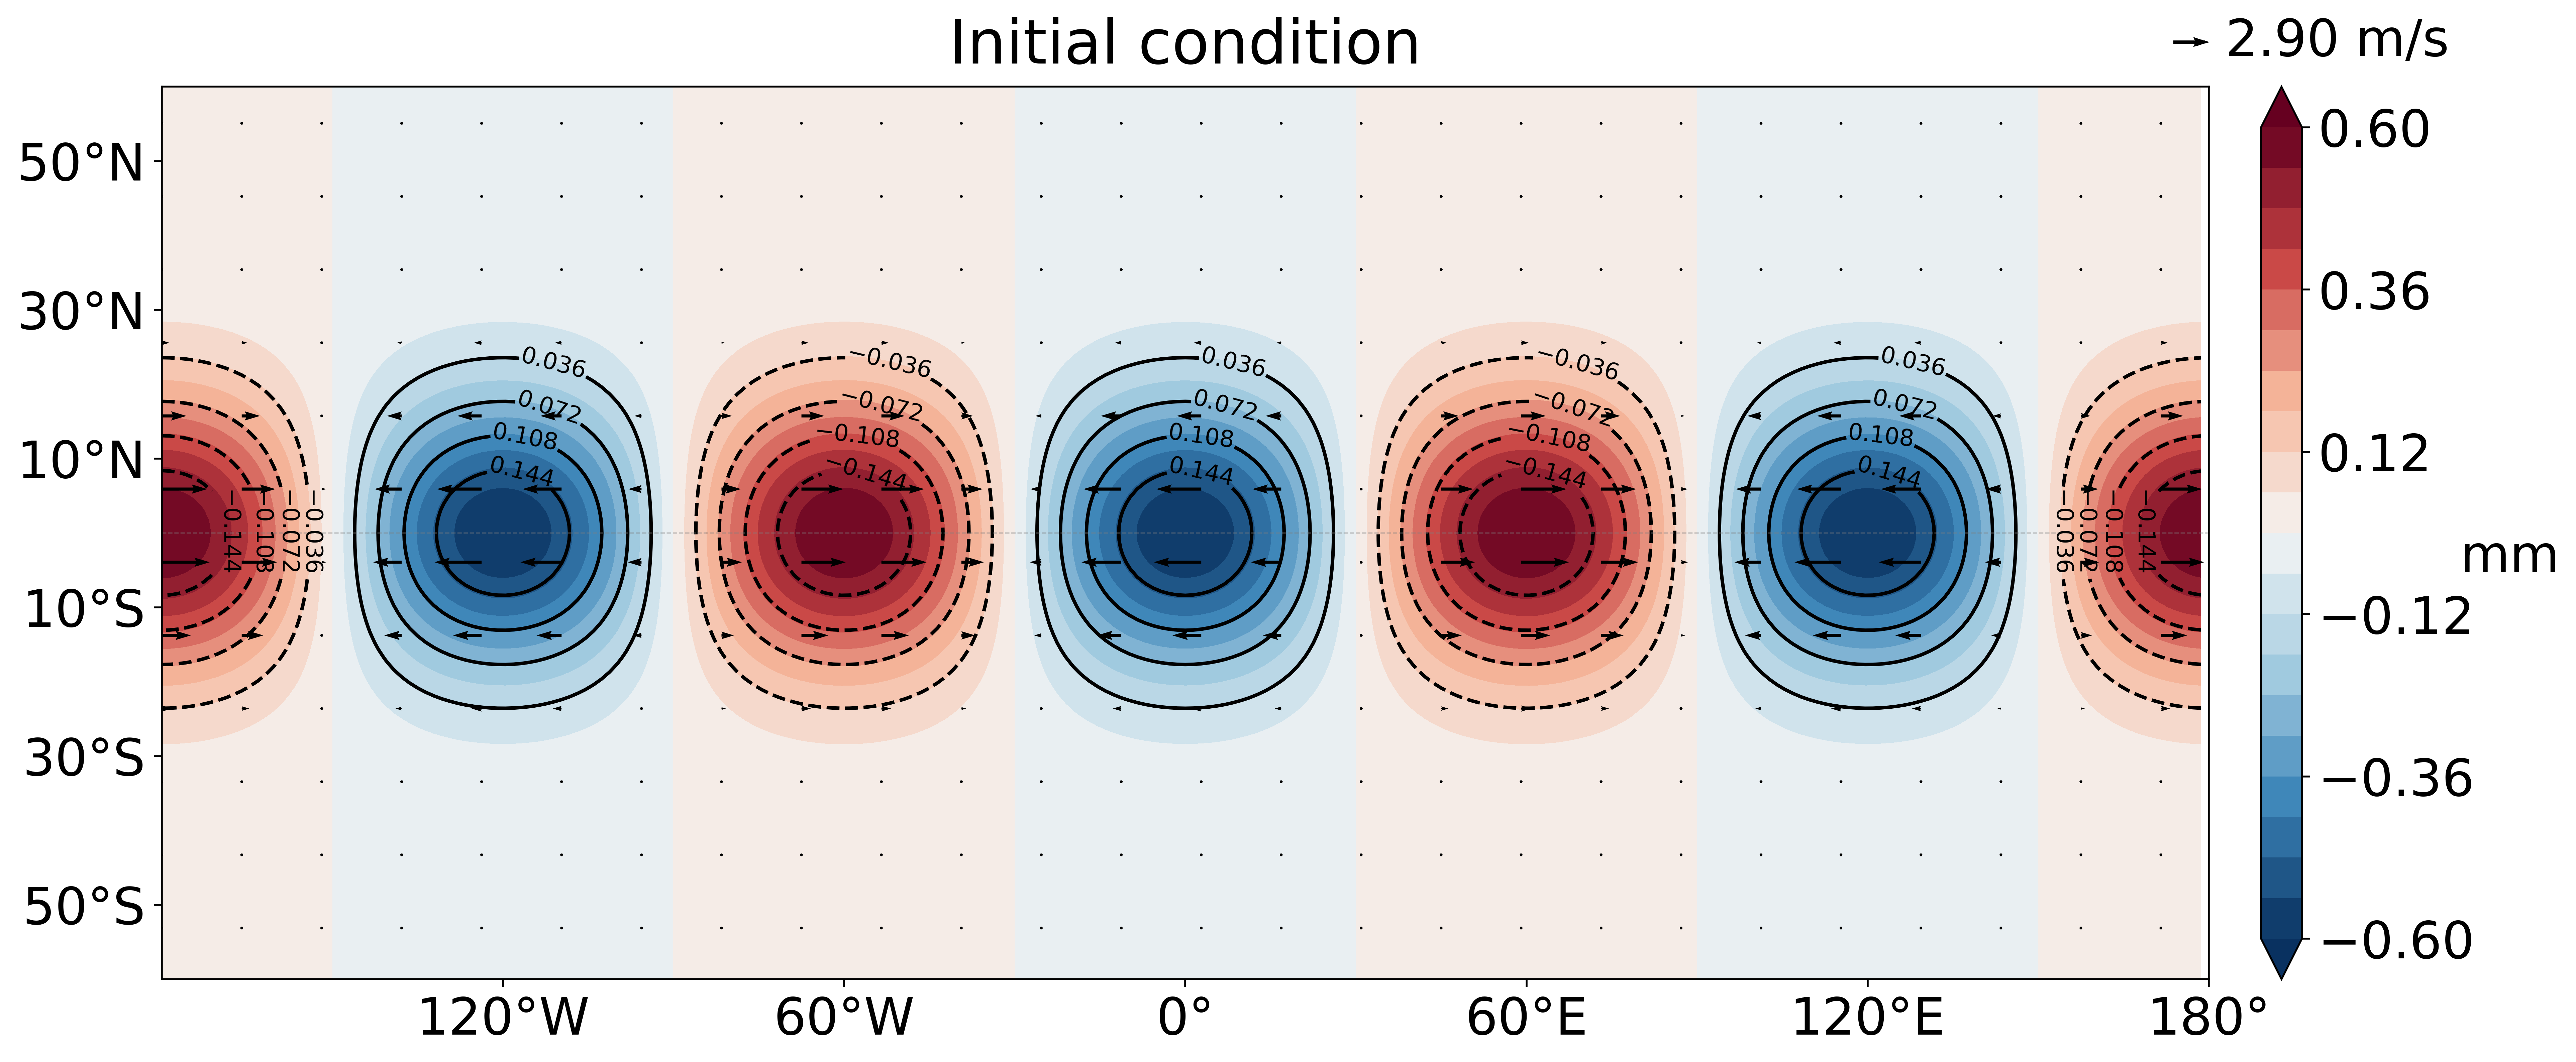

In [52]:
# Specify the type of wave for the initial condition
initial_wave = 'Kelvin'
n_wavelengths = 3
mode_number = 1

initial_condition_name = f"k={n_wavelengths:0.1f}_m={mode_number}_{initial_wave}-wave"
# initial_condition_name = f"k=1-5_m={mode_number}_{initial_wave}-wave"
# initial_condition_name = f"random-perturbations"
# initial_condition_name = f"moisture-blob"

print(f"Output directory: {output_file_directory}")
print(f"Initial condition: {initial_condition_name}")
print(f"===========================================\n")

#### Generate new initial condition
[
    generated_zonal_velocity,
    generated_meridional_velocity,
    generated_column_temperature,
    generated_column_moisture
] = generate_initial_condition('Kelvin', n_wavelengths = n_wavelengths, save_initial_condition=True)


##### Specify which initial condition to use when solving
# Generated
initial_zonal_velocity = generated_zonal_velocity
initial_meridional_velocity = generated_meridional_velocity
initial_column_temperature = generated_column_temperature
initial_column_moisture = generated_column_moisture

# half_field = generate_perlin_noise_2d((ny, nx//2), (16,16))
# full_field = np.concatenate((half_field, half_field[:, ::-1]), axis=1)

# initial_zonal_velocity = np.zeros((2, ny, nx))# 
# initial_meridional_velocity = np.zeros((2, ny, nx))# 
# initial_column_temperature = np.zeros((2, ny, nx))
# initial_column_moisture = np.zeros((2, ny, nx))
# initial_column_moisture[0] = np.einsum(
#     'i, j -> ji',
#     np.exp(-(zonal_gridpoints/EARTH_RADIUS)**2),
#     np.exp(-(meridional_gridpoints/length_scale)**2),
# )
    

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    (-180, 180), (-60, 60),
    10,10,
    True, 
    'converted',
    0.6,
    grid_scaling
)

# Plot the initial conditon below
plot_horizontal_structure(
    0,
    zonal_gridpoints,
    meridional_gridpoints,
    time_points,
    zonal_velocity = initial_zonal_velocity, 
    meridional_velocity = initial_meridional_velocity, 
    column_temperature = initial_column_temperature, 
    column_moisture = initial_column_moisture, 
    specified_output_file_directory=output_file_directory,
    specified_initial_condition_name=initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region),
    plotting_parameters = plotting_parameters
)

# Run Simulation

## Leapfrog Timestepping

In [ ]:
# save_downsampled = True
# overwrite_data = input("Overwrite existing data? [y/n]")

# for chunk in range(1, n_chunks+1):
#     chunk_length = nt//n_chunks
#     # chunk_length = nt
    
#     # Initialize the variables to simulate
#     zonal_velocity = np.zeros((chunk_length, ny, nx))
#     meridional_velocity = np.zeros((chunk_length, ny, nx))
#     column_temperature = np.zeros((chunk_length, ny, nx))
#     column_moisture = np.zeros((chunk_length, ny, nx))
    
#     print(f"Chunk {chunk}/{n_chunks}")
    
#     # The first chunk is initialized with preset initial conditions
#     if chunk == 1:
#         zonal_velocity[0] = initial_zonal_velocity[0]
#         meridional_velocity[0] = initial_meridional_velocity[0]
#         column_temperature[0] = initial_column_temperature[0]
#         column_moisture[0] = initial_column_moisture[0]
        
#         zonal_velocity[1] = initial_zonal_velocity[1]
#         meridional_velocity[1] = initial_meridional_velocity[1]
#         column_temperature[1] = initial_column_temperature[1]
#         column_moisture[1] = initial_column_moisture[1]
        
#     # Subsequent chunks are initialized with the output of the previous chunk
#     elif chunk > 1:
#         final_timesteps_model_data_input = xr.open_dataset(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
#         )

#         zonal_velocity[0] = final_timesteps_model_data_input['u'].sel(it=0).to_numpy()
#         meridional_velocity[0] = final_timesteps_model_data_input['v'].sel(it=0).to_numpy()
#         column_temperature[0] = final_timesteps_model_data_input['T'].sel(it=0).to_numpy()
#         column_moisture[0] = final_timesteps_model_data_input['q'].sel(it=0).to_numpy()
        
#         zonal_velocity[1] = final_timesteps_model_data_input['u'].sel(it=1).to_numpy()
#         meridional_velocity[1] = final_timesteps_model_data_input['v'].sel(it=1).to_numpy()
#         column_temperature[1] = final_timesteps_model_data_input['T'].sel(it=1).to_numpy()
#         column_moisture[1] = final_timesteps_model_data_input['q'].sel(it=1).to_numpy()
    
#     ### Step forward using leapfrong time-differencing
#     for it in tqdm(range(2,chunk_length), position=0, leave=True, ncols=100):
#         ### Transform to spectral space
#         ux_fft = fft(zonal_velocity[it-1],axis=1)
#         vy_fft = fft(meridional_velocity[it-1],axis=0)
#         Tx_fft = fft(column_temperature[it-1],axis=1)
#         Ty_fft = fft(column_temperature[it-1],axis=0)

#         ### Compute derivatives
#         dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft
#         dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
#         dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft
#         dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft

#         ### Transform back to physical space
#         dudx = np.real(ifft(dudx_fft, axis=1))
#         dvdy = np.real(ifft(dvdy_fft, axis=0))
#         dTdx = np.real(ifft(dTdx_fft, axis=1))
#         dTdy = np.real(ifft(dTdy_fft, axis=0))

#         ### Step forward with leapfrog scheme
#         zonal_velocity[it] = (zonal_velocity[it-2] - 2*time_step*(
#             - CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdx)
#         )

#         meridional_velocity[it] = (meridional_velocity[it-2] - 2*time_step*(
#             + CORIOLIS_PARAMETER*meridional_gridpoints[:,None]*zonal_velocity[it-1] 
#             + (gravity_wave_phase_speed**2/GROSS_DRY_STABILITY)*dTdy)
#         )

#         if moisture_coupling == True:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)
#                     - MOISTURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*column_moisture[it-1]
#                 )
#             )

#         elif moisture_coupling == False:
#             column_temperature[it] = (1/(1+2*TEMPERATURE_SENSITIVITY*(1+CLOUD_RADIATIVE_PARAMETER)*time_step))*(
#                 column_temperature[it-2] 
#                 - 2*time_step*(
#                     + GROSS_DRY_STABILITY*(dudx + dvdy)

#                 )
#             )

#         if simulation_moisture == True:
#             column_moisture[it] = (1/(1+2*MOISTURE_SENSITIVITY*time_step))*(
#                 column_moisture[it-2] 
#                 - 2*time_step*(
#                     - ZONAL_MOISTENING_PARAMETER*zonal_velocity[it-1]
#                     + MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*meridional_velocity[it-1] 
#                     - gross_moisture_stratification*(dudx + dvdy)
#                     - TEMPERATURE_SENSITIVITY*column_temperature[it-1]
#                 )
#             )

#         ### Meridional boundary condition
#         meridional_velocity[it,0] = 0.
#         meridional_velocity[it,-1] = 0.
        
        
        
#         # zonal_velocity[it,0] = 0.
#         # zonal_velocity[it,-1] = 0.
        
#         # column_temperature[it,0] = 0.
#         # column_temperature[it,-1] = 0.
        
#         # column_moisture[it,0] = 0.
#         # column_moisture[it,-1] = 0.
    
#     if save_downsampled:       
        
#         downsample_interval = round_to_multiple(np.floor(12*3600/time_step), n_chunks)
#         full_indices = np.array([i * downsample_interval for i in range(len(time_points[::downsample_interval]))])
#         chunked_indices = full_indices % (chunk_length-2)
#         data_indices = chunked_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
#         time_indices = full_indices[
#             (chunk-1)*(int(len(chunked_indices)/n_chunks)+1):chunk*(int(len(chunked_indices)/n_chunks)+1)
#         ]
        
        
#         # Store model variables in an xarray Dataset
#         downsampled_model_data = xr.Dataset(
#             data_vars = {
#                 'u' : (["time", "y", "x"], zonal_velocity[:-2,:,:][data_indices]),
#                 'v' : (["time", "y", "x"], meridional_velocity[:-2,:,:][data_indices]),
#                 'T' : (["time", "y", "x"], column_temperature[:-2,:,:][data_indices]),
#                 'q' : (["time", "y", "x"], column_moisture[:-2,:,:][data_indices])
#             },
#             coords = {
#             "x" : zonal_gridpoints,
#             "y" : meridional_gridpoints,
#             "time" : time_points[time_indices]
#             }
#         )
        
        
#         if os.path.exists(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"):
#             if overwrite_data == 'y':
#                 os.system(f"rm {output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc")
#                 print("Data overwritten")
#                 downsampled_model_data.to_netcdf(
#                     f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#                 )
#                 print("Downsampled data saved as netCDF")
            
#         else:
#             # Save the Dataset to a netCDF file
#             downsampled_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )

#             print(f"Chunk {chunk} downsampled data saved")

#     # Store the final two time steps of model variables in an xarray Dataset
#     final_timesteps_model_data = xr.Dataset(
#         data_vars = {
#             'u' : (["it", "y", "x"], zonal_velocity[-2:]),
#             'v' : (["it", "y", "x"], meridional_velocity[-2:]),
#             'T' : (["it", "y", "x"], column_temperature[-2:]),
#             'q' : (["it", "y", "x"], column_moisture[-2:])
#         },
#         coords = {
#         "x" : zonal_gridpoints,
#         "y" : meridional_gridpoints,
#         "it": np.array([0,1])
#         }
#     )
    
#     if os.path.exists(f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"):
#         if overwrite_data == 'y':
#             os.system(f"rm {output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc")
#             print("Data overwritten")
#             final_timesteps_model_data.to_netcdf(
#                 f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#             )
#             print("Final timestep data saved as netCDF")
#     else:
#         # Save the Dataset to a netCDF file
#         final_timesteps_model_data.to_netcdf(
#             f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
#         )

# print("done")

## Runge-Kutta Timestepping

In [ ]:
n_rk_steps = 3
save_downsampled = True
overwrite_data = input("Overwrite existing data? [y/n]: ")

low_pass_mask = np.ones_like((zonal_gridpoints))
low_pass_mask[nx//3:2*nx//3+1] = 0

for chunk in range(1, n_chunks+1):
    chunk_length = nt//n_chunks
    # chunk_length = nt
    
    # Initialize the variables to simulate
    zonal_velocity = np.zeros((chunk_length, ny, nx))
    meridional_velocity = np.zeros((chunk_length, ny, nx))
    column_temperature = np.zeros((chunk_length, ny, nx))
    column_moisture = np.zeros((chunk_length, ny, nx))
    
    print(f"Chunk {chunk}/{n_chunks}")
    
    # The first chunk is initialized with preset initial conditions
    if chunk == 1:
        zonal_velocity[0] = initial_zonal_velocity[0]
        meridional_velocity[0] = initial_meridional_velocity[0]
        column_temperature[0] = initial_column_temperature[0]
        column_moisture[0] = initial_column_moisture[0]
     
    # Subsequent chunks are initialized with the output of the previous chunk
    elif chunk > 1:
        final_timesteps_model_data_input = xr.load_dataset(
            f"{output_file_directory}/{initial_condition_name}_final-timesteps-model-data_chunk-{chunk-1}of{n_chunks}.nc"
        )

        zonal_velocity[0] = final_timesteps_model_data_input['u'].to_numpy()
        meridional_velocity[0] = final_timesteps_model_data_input['v'].to_numpy()
        column_temperature[0] = final_timesteps_model_data_input['T'].to_numpy()
        column_moisture[0] = final_timesteps_model_data_input['q'].to_numpy()

    print(moisture_coupling)
    ### Step forward using Runge-Kutta time-differencing
    for it in tqdm(range(1, chunk_length), position=0, leave=True, ncols=100):
        zonal_velocity_rk       = np.zeros((n_rk_steps+1, ny, nx))
        meridional_velocity_rk  = np.zeros((n_rk_steps+1, ny, nx))
        column_temperature_rk   = np.zeros((n_rk_steps+1, ny, nx))
        column_moisture_rk      = np.zeros((n_rk_steps+1, ny, nx))

        zonal_velocity_rk[0]       = zonal_velocity[it-1]
        meridional_velocity_rk[0]  = meridional_velocity[it-1]
        column_temperature_rk[0]   = column_temperature[it-1]
        column_moisture_rk[0]      = column_moisture[it-1]
        
        for rk_step in range(1, n_rk_steps+1):
            
            ### Transform to spectral space
            # zonal fft
            ux_fft = fft(zonal_velocity_rk[rk_step-1], axis=1)
            vx_fft = fft(meridional_velocity_rk[rk_step-1], axis=1)
            Tx_fft = fft(column_temperature_rk[rk_step-1], axis=1)
            qx_fft = fft(column_moisture_rk[rk_step-1], axis=1)

            # meridional fft
            uy_fft = fft(zonal_velocity_rk[rk_step-1], axis=0)
            vy_fft = fft(meridional_velocity_rk[rk_step-1], axis=0)
            Ty_fft = fft(column_temperature_rk[rk_step-1], axis=0)
            qy_fft = fft(column_moisture_rk[rk_step-1], axis=0)
            
            ### Compute first derivatives
            # zonal derivatives
            dudx_fft = 1j*zonal_wavenumber[None,:]*ux_fft #*low_pass_mask[None, :]
            dvdx_fft = 1j*zonal_wavenumber[None,:]*vx_fft #*low_pass_mask[None, :]
            dTdx_fft = 1j*zonal_wavenumber[None,:]*Tx_fft #*low_pass_mask[None, :]
            dqdx_fft = 1j*zonal_wavenumber[None,:]*qx_fft #*low_pass_mask[None, :]

            # meridional derivatives
            dudy_fft = 1j*meridional_wavenumber[:,None]*uy_fft
            dvdy_fft = 1j*meridional_wavenumber[:,None]*vy_fft
            dTdy_fft = 1j*meridional_wavenumber[:,None]*Ty_fft
            dqdy_fft = 1j*meridional_wavenumber[:,None]*qy_fft

            # kernel = np.array([1,-1])
            # dvdy = sp.ndimage.convolve1d(meridional_velocity_rk[rk_step-1], kernel, axis=0, mode='constant')/(meridional_step_size)
            # dvdy[0,:] = (meridional_velocity_rk[rk_step-1,1,:] - meridional_velocity_rk[rk_step-1,0,:])/(meridional_step_size)
            # dvdy[-1,:] = (meridional_velocity_rk[rk_step-1,-1,:] - meridional_velocity_rk[rk_step-1,-2,:])/(meridional_step_size)

            # dTdy = sp.ndimage.convolve1d(column_temperature_rk[rk_step-1], kernel, axis=0, mode='constant')/(meridional_step_size)
            # dTdy[0,:] = (column_temperature_rk[rk_step-1,1,:] - column_temperature_rk[rk_step-1,0,:])/(meridional_step_size)
            # dTdy[-1,:] = (column_temperature_rk[rk_step-1,-1,:] - column_temperature_rk[rk_step-1,-2,:])/(meridional_step_size)

            if simulation_diffusion:
                # ### Compute second derivatives
                # # zonal derivatives
                dudx_dx_fft = (1j*zonal_wavenumber[None,:])*dudx_fft
                dvdx_dx_fft = (1j*zonal_wavenumber[None,:])*dvdx_fft
                dTdx_dx_fft = (1j*zonal_wavenumber[None,:])*dTdx_fft
                dqdx_dx_fft = (1j*zonal_wavenumber[None,:])*dqdx_fft

                # meridional derivatives
                dudy_dy_fft = (1j*meridional_wavenumber[:,None])*dudy_fft
                dvdy_dy_fft = (1j*meridional_wavenumber[:,None])*dvdy_fft
                dTdy_dy_fft = (1j*meridional_wavenumber[:,None])*dTdy_fft
                dqdy_dy_fft = (1j*meridional_wavenumber[:,None])*dqdy_fft
    
            ### Transform back to physical space
            # zonal
            dudx = np.real(ifft(dudx_fft, axis=1))
            dvdx = np.real(ifft(dvdx_fft, axis=1))
            dTdx = np.real(ifft(dTdx_fft, axis=1))

            # meridional
            dudy = np.real(ifft(dudy_fft, axis=0))
            # dudy[0,:] = 0
            # dudy[-1,:] = 0
            dvdy = np.real(ifft(dvdy_fft, axis=0))
            # dvdy[0,:] = 0
            # dvdy[-1,:] = 0
            dTdy = np.real(ifft(dTdy_fft, axis=0))
            # dTdy[0,:] = 0
            # dTdy[-1,:] = 0
            
            if simulation_diffusion:
                # zonal
                dudx_dx = np.real(ifft(dudx_dx_fft, axis=1))
                dvdx_dx = np.real(ifft(dvdx_dx_fft, axis=1))
                dTdx_dx = np.real(ifft(dTdx_dx_fft, axis=1))
                dqdx_dx = np.real(ifft(dqdx_dx_fft, axis=1))

                # meridional
                dudy_dy = np.real(ifft(dudy_dy_fft, axis=0))
                dvdy_dy = np.real(ifft(dvdy_dy_fft, axis=0))
                dTdy_dy = np.real(ifft(dTdy_dy_fft, axis=0))
                dqdy_dy = np.real(ifft(dqdy_dy_fft, axis=0))

                # Calculate the laplacian for each variable (∇^2)
                laplacian_u = dudx_dx + dudy_dy
                laplacian_v = dvdx_dx + dvdy_dy
                laplacian_T = dTdx_dx + dTdy_dy
                laplacian_q = dqdx_dx + dqdy_dy
            
            #### Zonal Velocity
            zonal_velocity_forcing = (
                + CORIOLIS_PARAMETER * meridional_gridpoints[:, None] * meridional_velocity_rk[rk_step-1] 
                - (gravity_wave_phase_speed**2 / GROSS_DRY_STABILITY) * dTdx
                # - fringe_region_damping[:, None] * zonal_velocity_rk[rk_step-1]
                + DIFFUSIVITY * laplacian_u
            )

            zonal_velocity_rk[rk_step] = zonal_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*zonal_velocity_forcing

            #### Meridional Velocity
            meridional_velocity_forcing = (
                - CORIOLIS_PARAMETER * meridional_gridpoints[:,None] * zonal_velocity_rk[rk_step-1] 
                - (gravity_wave_phase_speed**2 / GROSS_DRY_STABILITY) * dTdy
                # - fringe_region_damping[:, None] * meridional_velocity_rk[rk_step-1]
                + DIFFUSIVITY * laplacian_v
            )

            meridional_velocity_rk[rk_step] = (
                meridional_velocity[it-1] + (time_step/(n_rk_steps - rk_step + 1))*meridional_velocity_forcing
            )

            #### Column Temperature
            if moisture_coupling == True:
                column_temperature_forcing = (
                    - GROSS_DRY_STABILITY * (dudx+dvdy)
                    + MOISTURE_SENSITIVITY * (1+CLOUD_RADIATIVE_PARAMETER) * column_moisture_rk[rk_step-1]
                    - TEMPERATURE_SENSITIVITY * (1+CLOUD_RADIATIVE_PARAMETER) * column_temperature_rk[rk_step-1]
                    # + MOISTURE_SENSITIVITY * np.exp(-(meridional_gridpoints/length_scale)**2)[:, None] * (1+CLOUD_RADIATIVE_PARAMETER) * column_moisture_rk[rk_step-1]
                    # - TEMPERATURE_SENSITIVITY * np.exp(-(meridional_gridpoints/length_scale)**2)[:, None] * (1+CLOUD_RADIATIVE_PARAMETER) * column_temperature_rk[rk_step-1]
                    # - fringe_region_damping[:, None] * column_temperature_rk[rk_step-1]
                    + DIFFUSIVITY * laplacian_T
                )

            else:
                column_temperature_forcing = (
                    - GROSS_DRY_STABILITY * (dudx+dvdy)
                    - TEMPERATURE_SENSITIVITY * (1+CLOUD_RADIATIVE_PARAMETER) * column_temperature_rk[rk_step-1]
                    # - fringe_region_damping[:, None] * column_temperature_rk[rk_step-1]
                    + DIFFUSIVITY * laplacian_T
                )

            column_temperature_rk[rk_step] = (
                column_temperature[it-1] + (time_step/(n_rk_steps - rk_step + 1))*column_temperature_forcing
            )

            #### Column Moisture
            if simulation_moisture == True:
                column_moisture_forcing = (
                    + (
                        ZONAL_MOISTENING_PARAMETER
                        # * (1-fringe_region_damping_function(meridional_gridpoints/METERS_PER_DEGREE, -45, 45, 15, 1))[:, None]
                        # * zonally_varying_sigma_x_function(half_width=5)[None, :]
                        * zonal_velocity_rk[rk_step-1]
                    )
                    - (
                        MERIDIONAL_MOISTENING_PARAMETER
                        # * (1-fringe_region_damping_function(meridional_gridpoints/METERS_PER_DEGREE, -45, 45, 10, 1))[:, None]
                        * (meridional_gridpoints*np.exp(-(meridional_gridpoints/3/length_scale)**2))[:,None]
                        * meridional_velocity_rk[rk_step-1]
                      )
                    # - (
                    #     MERIDIONAL_MOISTENING_PARAMETER
                    #     * (1-fringe_region_damping_function(-30, 30, 5, 1))[:, None]
                    #     * MERIDIONAL_OFFSET_PARAMETER
                    #     * meridional_velocity_rk[rk_step-1]
                    #   )
                    + gross_moisture_stratification * (dudx+dvdy)
                    - MOISTURE_SENSITIVITY    * column_moisture_rk[rk_step-1]
                    + TEMPERATURE_SENSITIVITY * column_temperature_rk[rk_step-1]
                    # - MOISTURE_SENSITIVITY    * np.exp(-(meridional_gridpoints/length_scale)**2)[:, None] * column_moisture_rk[rk_step-1]
                    # + TEMPERATURE_SENSITIVITY * np.exp(-(meridional_gridpoints/length_scale)**2)[:, None] * column_temperature_rk[rk_step-1]
                    # - fringe_region_damping[:, None] * column_moisture_rk[rk_step-1]
                    + DIFFUSIVITY * laplacian_q
                )
    
                column_moisture_rk[rk_step] = column_moisture[it-1] + (time_step/(n_rk_steps - rk_step + 1))*column_moisture_forcing

            #### Meridional Boundary conditions
            meridional_velocity_rk[rk_step, 0] = 0.
            meridional_velocity_rk[rk_step, -1] = 0.

            zonal_velocity_rk[rk_step, 0] = 0.
            zonal_velocity_rk[rk_step, -1] = 0.
            
            column_temperature_rk[rk_step, 0] = 0.
            column_temperature_rk[rk_step, -1] = 0.
            
            column_moisture_rk[rk_step, 0] = 0.
            column_moisture_rk[rk_step, -1] = 0.

        # The full time step is the result of the RK-time stepping
        zonal_velocity[it] = zonal_velocity_rk[-1]
        meridional_velocity[it] = meridional_velocity_rk[-1]
        column_temperature[it] = column_temperature_rk[-1]
        column_moisture[it] = column_moisture_rk[-1]

        # ### Meridional boundary conditions
        meridional_velocity[it,0] = 0.
        meridional_velocity[it,-1] = 0.

        zonal_velocity[it,0] = 0.
        zonal_velocity[it,-1] = 0.
        
        column_temperature[it,0] = 0.
        column_temperature[it,-1] = 0.
        
        column_moisture[it,0] = 0.
        column_moisture[it,-1] = 0.

    if save_downsampled:       
        
        downsample_interval = round_to_multiple(np.floor(6*3600/time_step), n_chunks)
        full_indices = np.array(
            [i * downsample_interval for i in range(len(time_points[::downsample_interval]))]
        )
        chunked_indices = full_indices % (chunk_length-1)
        full_data_indices = np.split(chunked_indices, np.where(np.diff(chunked_indices) < 0)[0] + 1)
        data_indices = full_data_indices[chunk-1]
        
        full_time_indices = np.split(full_indices, np.where(np.diff(chunked_indices) < 0)[0] + 1)
        time_indices = full_time_indices[chunk-1]

        print("Downsampled data")
        # Store model variables in an xarray Dataset
        downsampled_model_data = xr.Dataset(
            data_vars = {
                'u' : (["time", "y", "x"], zonal_velocity[:-1,:,:][data_indices]),
                'v' : (["time", "y", "x"], meridional_velocity[:-1,:,:][data_indices]),
                'T' : (["time", "y", "x"], column_temperature[:-1,:,:][data_indices]),
                'q' : (["time", "y", "x"], column_moisture[:-1,:,:][data_indices]),
            },
            coords = {
            "x" : zonal_gridpoints,
            "y" : meridional_gridpoints,
            "time" : time_points[time_indices]
            }
        )

        print(f"---- Saving data...")
        # Save the Dataset to a netCDF file
        downsampled_model_data.to_netcdf(
            f"{output_file_directory}/{initial_condition_name}" 
            + f"_downsampled-model-data_chunk-{chunk}of{n_chunks}.nc"
        )
        print(f"---- Data saved \n")

    print("Final timestep data")
    
    # Store the final time step of model variables in an xarray Dataset
    # if not os.path.exists(
    #     f"{output_file_directory}/{initial_condition_name}"
    #     + f"_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
    # ):
    print("---- Saving data...")
    final_timesteps_model_data = xr.Dataset(
        data_vars = {
            'u' : (["y", "x"], zonal_velocity[-1]),
            'v' : (["y", "x"], meridional_velocity[-1]),
            'T' : (["y", "x"], column_temperature[-1]),
            'q' : (["y", "x"], column_moisture[-1])
        },
        coords = {
        "x" : zonal_gridpoints,
        "y" : meridional_gridpoints,
        }
    )

    # else:
    #     print("---- Data already exists")
    #     if overwrite_data == 'y':
    #         print("------ Overwriting existing data...")
    #         final_timesteps_model_data = xr.load_dataset(
    #             f"{output_file_directory}/{initial_condition_name}" 
    #             + f"_final-timesteps-model-data_chunk-{chunk}of{n_chunks}.nc"
    #         )

    #         final_timesteps_model_data['u'][:] = zonal_velocity[-1]
    #         final_timesteps_model_data['v'][:] = meridional_velocity[-1]
    #         final_timesteps_model_data['T'][:] = column_temperature[-1]
    #         final_timesteps_model_data['q'][:] = column_moisture[-1]
            
    #     else:
    #         print("------ Existing data not overwritten")
            
    final_timesteps_model_data.to_netcdf(
        f"{output_file_directory}/{initial_condition_name}" 
        + f"_final-timesteps-model-data_chunk-{chunk}of{ n_chunks}.nc"
    )
    print(f"---- Data saved \n")

print("===================")
print("Simulation complete")

Overwrite existing data? [y/n]:  y


Chunk 1/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:36<00:00, 22.66it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 2/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:37<00:00, 22.61it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 3/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:37<00:00, 22.64it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 4/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:37<00:00, 22.57it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 5/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:36<00:00, 22.66it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 6/8
True


100%|███████████████████████████████████████████████████████████| 4914/4914 [03:36<00:00, 22.65it/s]


Downsampled data
---- Saving data...
---- Data saved 

Final timestep data
---- Saving data...
---- Data saved 

Chunk 7/8
True


 45%|██████████████████████████▊                                | 2230/4914 [01:38<01:58, 22.67it/s]

In [ ]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(1, 1, figsize=(16,6))

ax.set_title(r'Moisture and temperature adjustment timescales', pad=15)
ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    3600*MOISTURE_SENSITIVITY*np.exp(-(meridional_gridpoints/(1.5*length_scale))**2),
    lw=4,
    color=bmh_colors('blue')
)

ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    3600*TEMPERATURE_SENSITIVITY*np.exp(-(meridional_gridpoints/(1.5*length_scale))**2),
    lw=4,
    color=bmh_colors('red')
)

ax.axhline(y=3600*MOISTURE_SENSITIVITY, ls=':', label=r'Ahmed-21 $\tau_{q}$', color=bmh_colors('blue'))
ax.axhline(y=3600*TEMPERATURE_SENSITIVITY, ls=':', label=r'Ahmed-21 $\tau_{t}$', color=bmh_colors('red'))

ax.legend(loc='best', fontsize=18)
ax.set_xticks(np.arange(-60, 75, 15), labels = mjo.tick_labeller(np.arange(-60, 75, 15), 'lat'))
tick_locations = [1/120, 1/20, 1/10, 1/6, 1/4.5, 1/3.33333, 1/2.5, 1/2]
tick_labels = [f"{1/(tick_locations[i]):0.1f}" for i in range(len(tick_locations))]
ax.set_yticks(ticks=tick_locations, labels=tick_labels)
ax.set_ylabel('hr', rotation=0, va='center', labelpad=25)
plt.show()

# Export variables

In [51]:
# Get all local variables in the current namespace
experiment_variables = dict(
    simulation_moisture = simulation_moisture,
    moisture_advection = moisture_advection,
    simulation_damping = simulation_damping,
    moisture_coupling = moisture_coupling,
    simulation_diffusion = simulation_diffusion,
    fringe_region = fringe_region,
    GRAVITY = GRAVITY,
    EQUIVALENT_DEPTH = EQUIVALENT_DEPTH,
    CORIOLIS_PARAMETER = CORIOLIS_PARAMETER,
    EARTH_RADIUS = EARTH_RADIUS,
    AIR_DENSITY = AIR_DENSITY,
    WATER_DENSITY = WATER_DENSITY,
    LATENT_HEAT = LATENT_HEAT,
    SPECIFIC_HEAT = SPECIFIC_HEAT,
    DIFFUSIVITY = DIFFUSIVITY,
    # laplacian_u = laplacian_u,
    # laplacian_v = laplacian_v,
    # laplacian_T = laplacian_T,
    # laplacian_q = laplacian_q,
    METERS_PER_DEGREE = METERS_PER_DEGREE,
    SECONDS_PER_DAY = SECONDS_PER_DAY,
    COLUMN_AVERAGE_MASS = COLUMN_AVERAGE_MASS,
    GROSS_DRY_STABILITY = GROSS_DRY_STABILITY,
    MOISTURE_SENSITIVITY = MOISTURE_SENSITIVITY,
    TEMPERATURE_SENSITIVITY = TEMPERATURE_SENSITIVITY,
    CLOUD_RADIATIVE_PARAMETER = CLOUD_RADIATIVE_PARAMETER,
    sigma_x_multiplier = sigma_x_multiplier,
    sigma_y_multiplier = sigma_y_multiplier,
    ZONAL_MOISTENING_PARAMETER = ZONAL_MOISTENING_PARAMETER,
    MERIDIONAL_MOISTENING_PARAMETER = MERIDIONAL_MOISTENING_PARAMETER,
    MERIDIONAL_OFFSET_PARAMETER = MERIDIONAL_OFFSET_PARAMETER,
    gravity_wave_phase_speed = gravity_wave_phase_speed,
    time_scale = time_scale,
    length_scale = length_scale,
    gross_moisture_stratification = gross_moisture_stratification,
    effective_sensitivity = effective_sensitivity,
    effective_gross_moist_stability = effective_gross_moist_stability,
    scaled_zonal_parameter = scaled_zonal_parameter,
    scaled_meridional_parameter = scaled_meridional_parameter,
    n_days = n_days,
    n_chunks = n_chunks,
    n_time_steps = n_time_steps,
    meridional_domain_length = meridional_domain_length,
    zonal_domain_length = zonal_domain_length,
    nt = nt,    
    nx = nx,
    ny = ny,
    zonal_grid_spacing = zonal_grid_spacing,
    meridional_grid_spacing = meridional_grid_spacing,
    simulation_length = simulation_length,
    time_step = time_step,
    zonal_step_size = zonal_step_size,
    meridional_step_size = meridional_step_size,
    CFL_x = CFL_x,
    CFL_y = CFL_y,
    fringe_region_latitude = fringe_region_latitude,
    fringe_region_width = fringe_region_width,
    fringe_region_strength = fringe_region_strength,
    grid_scaling = grid_scaling,
    additional_notes = additional_notes,
    simulation_name = simulation_name,
    output_file_directory = output_file_directory,
    initial_wave = initial_wave,
    n_wavelengths = n_wavelengths,
    mode_number = mode_number,
    initial_condition_name = initial_condition_name,
    n_rk_steps = n_rk_steps,
    save_downsampled = save_downsampled,
)

# Save to a JSON file
with open(
    f"{output_file_directory}/experiment_variables.json", 'w') as json_file:
    json.dump(experiment_variables, json_file)

print("Variables stored as JSON")

Variables stored as JSON


# Compile downsampled data

In [ ]:
# Use the most recently run experiment
specified_output_file_directory = output_file_directory
# specified_initial_condition_name = initial_condition_name

# Choose a previous experiment
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=0.0_ny=1.00_S=0.003_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_limited-advection_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=0.00_implicit_BC_damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.00_epsq=0.00_r=0.0_nx=0.0_ny=0.00_finite-difference-test_free-dry-uncoupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_epsq=epsq(y)_epst=epst(y)_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_exponential-base-state_diffusive-damped-moist-coupled-simulation"
# specified_output_file_directory = "output/Ahmed-21/epst=0.50_epsq=0.17_r=0.2_nx=1.0_ny=1.00_limited-advection_damped-moist-coupled-simulation"
specified_initial_condition_name = 'k=2.0_m=1_Kelvin-wave'

downsampled_subfiles = []
n_chunks_load = 8
for c in range(1,n_chunks_load+1):
    # downsampled_subfiles.append(f"{output_file_directory}/{initial_condition_name}_downsampled-model-data_chunk-{c}of{n_chunks}.nc")
    downsampled_subfiles.append(
        f"{specified_output_file_directory}/{specified_initial_condition_name}_downsampled-model-data_chunk-{c}of{n_chunks_load}.nc"
    )

# downsampled_subfiles = sorted(
#     glob(
#         f"{specified_output_file_directory}/{specified_initial_condition_name}_downsampled-model-data_chunk*of{n_chunks}.nc"
#     )
# )
    
downsampled_data_list = []
for downsampled_file in downsampled_subfiles:
    print(downsampled_file)
    downsampled_data_chunked = xr.load_dataset(downsampled_file)
    downsampled_data_list.append(downsampled_data_chunked)

downsampled_data = xr.concat(downsampled_data_list, dim='time')

output_zonal_velocity = downsampled_data['u'].to_numpy()
output_meridional_velocity = downsampled_data['v'].to_numpy()
output_column_temperature = downsampled_data['T'].to_numpy()
output_column_moisture = downsampled_data['q'].to_numpy()

output_zonal_gridpoints = downsampled_data.x.to_numpy()
output_meridional_gridpoints = downsampled_data.y.to_numpy()
downsampled_timepoints = downsampled_data.time.to_numpy()

output_wavenumber = eval(specified_initial_condition_name.split('_')[0].split('=')[-1])/EARTH_RADIUS

print("downsampled data compiled")

# Visualize Simulation Output

## Horizontal Structure

In [ ]:
# plot_horizontal_structure(
#     np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 30)[0][0],
#     # -1,
#     output_zonal_gridpoints,
#     output_meridional_gridpoints,
#     downsampled_timepoints,
#     output_zonal_velocity, 
#     output_meridional_velocity, 
#     output_column_temperature, 
#     output_column_moisture, 
#     specified_output_file_directory=specified_output_file_directory,
#     specified_initial_condition_name=specified_initial_condition_name,
#     # xlims=(-180,180),
#     # xlims=(-70, 70),
#     # ylims = (
#     #     -np.max(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE)), 
#     #     np.max(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE))
#     # ),
#     # xlims=(0,160),
#     ylims=(-30,30),
#     # zonal_quiver_plot_spacing = 2,
#     # meridional_quiver_plot_spacing = 4, 
#     zonal_quiver_plot_spacing = 5,
#     meridional_quiver_plot_spacing = 4, 
#     save_plot=False, 
#     plotting_units='converted',
#     moisture_anomaly_scaling = 0.6,
# )

physical_parameters = (
    SPECIFIC_HEAT, 
    LATENT_HEAT,
    WATER_DENSITY,
    COLUMN_AVERAGE_MASS,
    EARTH_RADIUS,
    METERS_PER_DEGREE,
    SECONDS_PER_DAY,
)

plotting_parameters = (
    (-180, 180), (-30, 30),
    5,4,
    True, 
    'converted',
    0.6,
    grid_scaling
)

# Plot the initial conditon below
plot_horizontal_structure(
    np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 30)[0][0],
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    zonal_velocity = output_zonal_velocity, 
    meridional_velocity = output_meridional_velocity, 
    column_temperature = output_column_temperature, 
    column_moisture = output_column_moisture, 
    specified_output_file_directory = specified_output_file_directory,
    specified_initial_condition_name = specified_initial_condition_name,
    physical_parameters = physical_parameters,
    simulation_parameters = (simulation_moisture, fringe_region),
    plotting_parameters = plotting_parameters
)

## 3-D structure

In [ ]:
# vertical_gridpoints = np.linspace(0, 17e3, 64)
# scale_height = 10e3
# moisture_structure = np.exp(-vertical_gridpoints/scale_height)
# vertical_wind_structure = -np.cos(2*np.pi*vertical_gridpoints/np.max(vertical_gridpoints))
# horizontal_wind_structure = np.sin(2*np.pi*vertical_gridpoints/np.max(vertical_gridpoints))

# equator_index = np.abs(meridional_gridpoints - 0*METERS_PER_DEGREE).argmin()
# # t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 45).argmin()
# t=0
# # plt.figure()
# # plt.plot(
# #     vertical_wind_structure,
# #     vertical_gridpoints
# # )

# # plt.plot(
# #     horizontal_wind_structure,
# #     vertical_gridpoints
# # )

# full_moisture = np.einsum(
#     'i, jk-> kji',
#     moisture_structure,
#     output_column_moisture[t]
# )

# full_zonal_wind = np.einsum(
#     'i, jk-> kji',
#     horizontal_wind_structure,
#     output_zonal_velocity[t]
# )

# fig = plt.figure(figsize=(16.5, 11))
# ax = fig.add_subplot(111, projection='3d')

# [X, Y, Z] = np.meshgrid(meridional_gridpoints/1e3, zonal_gridpoints/1e3, vertical_gridpoints/1e3)
# data = full_zonal_wind
# kw = {
#     'vmin': data.min(),
#     'vmax': data.max(),
#     'levels': np.linspace(data.min(), data.max(), 21),
#     'cmap' : Ahmed_cmap
# }

# # Plot contour surfaces
# _ = ax.contourf(
#     X[:, :, 0], Y[:, :, 0], data[:, :, 0],
#     zdir='z', offset=0, **kw
# )
# _ = ax.contourf(
#     X[0, :, :], data[0, :, :], Z[0, :, :],
#     zdir='y', offset=Y.max(), **kw
# )
# C = ax.contourf(
#     data[:, equator_index, :], Y[:, equator_index, :], Z[:, equator_index, :],
#     zdir='x', offset=0, **kw
# )

# # # Set limits of the plot from coord limits
# # xmin, xmax = X.min(), X.max()
# # ymin, ymax = Y.min(), Y.max()
# # zmin, zmax = Z.min(), Z.max()
# # ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# # # Plot edges
# # edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
# # ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
# # ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
# # ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# # # Set labels and zticks
# # ax.set(
# #     xlabel='X [km]',
# #     ylabel='Y [km]',
# #     zlabel='Z [m]',
# #     zticks=[0, -150, -300, -450],
# # )

# # Set zoom and angle view
# # ax.view_init(40, -30, 0)
# ax.set_box_aspect((1, 1, 1), zoom=0.9)
# ax.set_zlim(0, 20)

# # Colorbar
# # fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='<q> [J kg m^-2]')

# # Show Figure
# plt.show()

## Meridional Structure

In [ ]:
starting_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 70)[0][0]
ending_frame = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 99)[0][0]
frame_interval = 1
lon_index = np.argmax(output_column_moisture[0, ny//2, :]) 

plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,6))
ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")

axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')

u_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_zonal_velocity[starting_frame, :, lon_index],
    color=bmh_colors('purple'),
    label='u'
)

v_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_meridional_velocity[starting_frame, :, lon_index],
    color=bmh_colors('green'),
    label='v'
)

T_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_column_temperature[starting_frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    label=r"$\frac{c}{M_s}\langle T \rangle$",
)

q_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_column_moisture[starting_frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    label=r"$\frac{c}{M_q}\langle q \rangle$",
)

if fringe_region:
    ax.axvline(x=fringe_region_latitude, color='k', ls=':')
    ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
        
    ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
    ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')

# Set axis parameters
ax.set_ylim(-20, 20)
ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
# ax.set_xlim(60, 75)
ax.set_ylabel('Amplitude (m/s)')

ax.legend(fontsize=12, loc='upper right')

def update(frame):

    # Clear the plot each frame
    ax.clear()

    ax.set_title(f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days")

    axh_line = ax.axhline(y=0, color='k', lw=2, ls=':')
    
    u_line = ax.plot(
    meridional_gridpoints/METERS_PER_DEGREE,
    output_zonal_velocity[frame, :, lon_index],
    color=bmh_colors('purple'),
    label='u'
    )
    
    v_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_meridional_velocity[frame, :, lon_index],
        color=bmh_colors('green'),
        label='v'
    )
    
    T_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_column_temperature[frame, :, lon_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
        color=bmh_colors('blue'),
        label=r"$\frac{c}{M_s}\langle T \rangle$",
    )
    
    q_line = ax.plot(
        meridional_gridpoints/METERS_PER_DEGREE,
        output_column_moisture[frame, :, lon_index]*gravity_wave_phase_speed/gross_moisture_stratification,
        color=bmh_colors('red'),
        label=r"$\frac{c}{M_q}\langle q \rangle$",
    )    

    if fringe_region:
        ax.axvline(x=fringe_region_latitude, color='k', ls=':')
        ax.axvline(x=-fringe_region_latitude, color='k', ls=':')
            
        ax.axvline(x=(fringe_region_latitude-fringe_region_width), color='k', ls=':')
        ax.axvline(x=-(fringe_region_latitude-fringe_region_width), color='k', ls=':')
    
    # Set axis parameters
    ax.set_ylim(-20, 20)
    # ax.set_ylim(-0.5, 0.5)
    ax.set_xticks(ticks=np.arange(-60,80,20), labels=mjo.tick_labeller(np.arange(-60,80,20), 'lat'))
    # ax.set_xlim(60, 75)
    ax.set_ylabel('Amplitude (m/s)')

    ax.legend(fontsize=12, loc='upper right')
    
    return u_line, v_line, T_line, q_line
    
frames_array = range(starting_frame, ending_frame, frame_interval)

# Run the animation
anim = FuncAnimation(fig, update, frames = tqdm(frames_array, position=0, leave=True, ncols=100), interval=50)

anim.save(
    f"{output_file_directory}/{initial_condition_name}_meridional-structure_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)

### Meridional advection profile

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        MERIDIONAL_MOISTENING_PARAMETER
        *output_meridional_gridpoints[:,None]
        *output_meridional_velocity
    )[1, :, 50]
)
plt.twinx()
plt.plot(
    output_meridional_gridpoints/METERS_PER_DEGREE,
    (
        MERIDIONAL_MOISTENING_PARAMETER
        *output_meridional_gridpoints[:,None]*np.exp(-(output_meridional_gridpoints/4/length_scale)**2)[:,None]
        *output_meridional_velocity
    )[1, :, 50],
    color='red'
)
plt.show()

In [ ]:
plot_horizontal_structure(
    np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 35)[0][0],
    # 0,
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints,
    output_zonal_velocity, 
    output_meridional_velocity, 
    output_column_temperature, 
    output_column_moisture, 
    xlims=(-180,180),
    # xlims=(60, 65),
    ylims = (-np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE)), np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE))),
    # ylims=(70,75),
    # ylims=(25,50),
    # zonal_quiver_plot_spacing = 2,
    # meridional_quiver_plot_spacing = 4, 
    zonal_quiver_plot_spacing = 10,
    meridional_quiver_plot_spacing = 10, 
    save_plot=False, 
    plotting_units='converted',
    moisture_anomaly_scaling = 0.6
)

def test(frame):
    plot_horizontal_structure(
        # np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 35)[0][0],
        frame,
        output_zonal_gridpoints,
        output_meridional_gridpoints,
        downsampled_timepoints,
        output_zonal_velocity, 
        output_meridional_velocity, 
        output_column_temperature, 
        output_column_moisture, 
        xlims=(-180,180),
        # xlims=(60, 65),
        ylims = (-np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE)), np.max(np.abs(meridional_gridpoints/METERS_PER_DEGREE))),
        # ylims=(70,75),
        # ylims=(25,50),
        # zonal_quiver_plot_spacing = 2,
        # meridional_quiver_plot_spacing = 4, 
        zonal_quiver_plot_spacing = 10,
        meridional_quiver_plot_spacing = 10, 
        save_plot=False, 
        plotting_units='converted',
        moisture_anomaly_scaling = 0.6
    )

starting_frame = np.abs(downsampled_timepoints - 0*SECONDS_PER_DAY).argmin()
ending_frame = np.abs(downsampled_timepoints - 40*SECONDS_PER_DAY).argmin()
frame_interval = 24

frames_array = range(starting_frame, ending_frame, frame_interval)

# Run the animation
anim = FuncAnimation(fig, test, frames = tqdm(frames_array, position=0, leave=True, ncols=100), interval=50)

# anim.save(
#     f"{output_file_directory}/{initial_condition_name}_test_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
#     dpi=300
# )

print("done!")

## Zonal Structure

In [ ]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))

lat_index = -2

# ax.set_title(f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days")
ax.set_title(
        f"Time: {downsampled_timepoints[0]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )
q_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'),
    label='<q>'
)
q_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_moisture[0,  lat_index, :]/np.max(np.abs(output_column_moisture[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('red'), 
    ls='--'
)

T_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'),
    label='<T>'
)
T_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_column_temperature[0,  lat_index, :]/np.max(np.abs(output_column_temperature[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('blue'), 
    ls='--'
)

u_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'),
    label='u'
)
u_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_zonal_velocity[0,  lat_index, :]/np.max(np.abs(output_zonal_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('purple'), 
    ls='--'
)

# Meridional velocity
v_phase1 = ax.plot(
    output_zonal_gridpoints/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'),
    label='v'
)
v_phase2 = ax.plot(
    (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
    output_meridional_velocity[0, lat_index, :]/np.max(np.abs(output_meridional_velocity[0, lat_index,:])), 
    lw=3, 
    color=bmh_colors('green'), 
    ls='--'
)

ax.legend(loc='upper right', fontsize=12)

ax.set_ylabel('<q>')
ax.set_xlabel('Phase')

ax.set_xlim(100, 300) 
ax.set_ylim(-1.1, 1.1)

def update(frame):

    # Clear the plot each frame
    ax.clear()

    ax.set_title(
        f"Time: {downsampled_timepoints[frame]/SECONDS_PER_DAY:0.1f} days, latitude: {meridional_gridpoints[lat_index]/METERS_PER_DEGREE:0.1f}"
    )

    # Column moisture
    q_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'),
        label='<q>'
    )
    q_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_moisture[frame, lat_index, :]/np.max(np.abs(output_column_moisture[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('red'), 
        ls='--'
    )

    # Column temperature
    T_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'),
        label='<T>'
    )
    T_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_column_temperature[frame, lat_index, :]/np.max(np.abs(output_column_temperature[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('blue'), 
        ls='--'
    )

    # Zonal velocity
    u_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'),
        label='u'
    )
    u_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_zonal_velocity[frame, lat_index, :]/np.max(np.abs(output_zonal_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('purple'), 
        ls='--'
    )

    # Meridional velocity
    v_phase1 = ax.plot(
        output_zonal_gridpoints/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'),
        label='v'
    )
    v_phase2 = ax.plot(
        (zonal_domain_length+output_zonal_gridpoints)/METERS_PER_DEGREE, 
        output_meridional_velocity[frame, lat_index, :]/np.max(np.abs(output_meridional_velocity[frame, lat_index,:])), 
        lw=3, 
        color=bmh_colors('green'), 
        ls='--'
    )
    
    ax.legend(loc='upper right', fontsize=12)
    
    # ax.set_ylabel('')
    ax.set_xlabel('Phase')
    
    ax.set_xlim(100, 300)
    ax.set_ylim(-1.1, 1.1)
    return q_phase1, q_phase2, T_phase1, T_phase2, u_phase1, u_phase2, v_phase1, v_phase2

# Run the animation
anim = FuncAnimation(fig, update, frames = tqdm(range(0, 400, 6), position=0, leave=True, ncols=100), interval=300)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_BC_phase_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)


In [ ]:
equator_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - 0).argmin()

t = 0

averaging_latitudes = np.where(np.abs(meridional_gridpoints)/METERS_PER_DEGREE <= 30)[0]
# averaging_latitudes = equator_index
averaged_column_moisture = np.mean(output_column_moisture[:, averaging_latitudes, :], axis=1)
# averaged_column_moisture = output_column_moisture[:, equator_index, :]
normed_column_moisture = averaged_column_moisture#/np.max(averaged_column_moisture, axis=1)[:, None]
zonal_fft = fft(normed_column_moisture, axis=1)

plt.style.use('bmh')
plt.figure(figsize=(16.5,6.5))
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 0).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 0).argmin()])))
    ),
    label='Day 0'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()])))
    ),
    label='Day 30'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 60).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 60).argmin()])))
    ),
    label='Day 60'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 90).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 90).argmin()])))
    ),
    label='Day 90'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 120).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 120).argmin()])))
    ),
    label='Day 120'
)
plt.plot(
    EARTH_RADIUS*np.fft.fftshift(zonal_wavenumber), 
    (
        np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 150).argmin()]))
        - np.max(np.log10(np.fft.fftshift(zonal_fft[np.abs(downsampled_timepoints/SECONDS_PER_DAY - 150).argmin()])))
    ),
    label='Day 150'
)

plt.axhline(y=-5, color='gray', alpha=0.5)

plt.title(r'log$_{10} ( \langle q \rangle )$', pad=15)
# plt.ylabel()
plt.xlabel('k')
plt.xlim(-50,50)
plt.xticks(np.arange(-50, 60, 10))

plt.legend(fontsize=12, loc='upper right')
plt.gca().set_aspect('auto')
plt.show()

## Temporal Structure

In [ ]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':24})

plotting_time_points = downsampled_timepoints

south_lat = -30
north_lat = 30
south_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - south_lat).argmin()
north_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - north_lat).argmin()
# near_equatorial_latitudes = np.where(np.abs(output_meridional_gridpoints/METERS_PER_DEGREE) <= 15)[0]
near_equatorial_column_temperature = np.mean(
    output_column_temperature[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_column_moisture = np.mean(
    output_column_moisture[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_zonal_velocity = np.mean(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :],
    axis=1
)
near_equatorial_meridional_velocity = np.mean(
    output_meridional_velocity[:, south_lat_index:north_lat_index, :],
    axis=1
)

max_index = np.argmax(near_equatorial_column_temperature)
[t_index, x_index] = np.unravel_index(max_index, [nt, nx])

[fig, ax] = plt.subplots(figsize=(16,6))
ax.set_title(
    (
        f"{np.abs(south_lat)}°S-{np.abs(north_lat)}°N averaged {initial_wave} wave amplitude \n over time," 
      + r" ε$_t$ = " + f"{3600*TEMPERATURE_SENSITIVITY:0.3f}" + r" hr$^{-1},$"
      + r" ε$_q$ = " + f"{3600*MOISTURE_SENSITIVITY:0.3f}" + r" hr$^{-1}$"
    ), pad=15
)

ax.axhline(
    y=0,
    color='black',
    ls='--',
    alpha=0.75
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_temperature[:, x_index]*gravity_wave_phase_speed/GROSS_DRY_STABILITY, 
    lw=3, 
    label=r"$\frac{c}{M_s}\langle T \rangle$",
    color=bmh_colors('blue')
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    near_equatorial_column_moisture[:, x_index]*gravity_wave_phase_speed/gross_moisture_stratification, 
    lw=3, 
    label=r"$\frac{c}{M_q}\langle q \rangle$",
    color=bmh_colors('red')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_zonal_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='u',
    color=bmh_colors('purple')
    
)

ax.plot(
    plotting_time_points/SECONDS_PER_DAY, 
    -near_equatorial_meridional_velocity[:, x_index], 
    lw=3, 
    ls='--',
    label='v',
    color=bmh_colors('green')
)

# Maximum column temperature
ax.axhline(
    y=np.max(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_temperature)*gravity_wave_phase_speed/GROSS_DRY_STABILITY,
    color=bmh_colors('blue'),
    ls=':',
    alpha=0.75
)

# Maximum column moisture
ax.axhline(
    y=np.max(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.axhline(
    y=np.min(near_equatorial_column_moisture)*gravity_wave_phase_speed/gross_moisture_stratification,
    color=bmh_colors('red'),
    ls=':',
    alpha=0.75
)

ax.set_xlabel('Time (days)')
ax.set_ylabel(r"$\frac{m}{s}$", rotation=0, labelpad=20, fontsize=32)

ax.legend(loc='best', fontsize=18)

if initial_wave == 'EIG' or initial_wave == 'WIG':
    plt.xlim(-1, 5)

    
# plt.xlim(-1, 15)
# plt.ylim(-100,100)

# plt.show()
plt.savefig(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_temporal-structure_{time.strftime('%Y%m%d-%H%M')}.png", 
    bbox_inches='tight'
)

## Frequency & Growth Rate

In [ ]:
start_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 10)[0][0]
stop_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 70)[0][0]
signal = near_equatorial_zonal_velocity[start_index:stop_index, 10]

signal_duration = downsampled_timepoints[start_index:stop_index][-1]
sampling_frequency = 1/np.diff(downsampled_timepoints)[0]
n_samples = int(sampling_frequency*signal_duration)
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * sampling_frequency)

linear_fit = np.polyfit(downsampled_timepoints[start_index:stop_index], np.log(amplitude_envelope), 1)
exponential_fit = np.exp(np.polyval(linear_fit, downsampled_timepoints[start_index:stop_index]))
wave_growth_rate = linear_fit[0]*SECONDS_PER_DAY

signal_frequencies = np.fft.fftfreq(len(signal), 1/sampling_frequency)
signal_fft = np.fft.fft(signal)
wave_frequency = np.abs(signal_frequencies[np.argmax(signal_fft)])

zonal_slice = near_equatorial_zonal_velocity[200, :]
output_wavenumber = zonal_wavenumber[np.argmax(np.abs(np.fft.fft(zonal_slice)))]

print(f"Frequency:   {2*np.pi*SECONDS_PER_DAY*wave_frequency:0.3f} day^-1")
print(f"Period:      {1/(SECONDS_PER_DAY*wave_frequency):0.3f} day")
print(f"Growth Rate: {wave_growth_rate:0.3f} day^-1")
print(f"Phase Speed: {2*np.pi*wave_frequency/(output_wavenumber):0.3f} m/s")

plt.style.use('bmh')
plt.figure(figsize=(16,4))
plt.plot(
    downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
    signal, 
    label='Signal', 
    color=bmh_colors('purple'),
    ls='--'
)
plt.plot(
    downsampled_timepoints[start_index:stop_index]/SECONDS_PER_DAY, 
    exponential_fit, 
    label='Exp. envelope', 
    color='black',
    lw=1
)
plt.axhline(y=0, color='k', ls=':')

plt.legend(loc='upper left')
plt.xlabel('Days')
plt.ylabel('Amplitude')
plt.show()

## Pattern & Phase Speed Correlation

In [ ]:
# Find the y_index corresponding to the equator
equator_index = np.abs(meridional_gridpoints - 0*METERS_PER_DEGREE).argmin()

# instantaneous_phase_speed = {}
# regions = {
#     '10°S - 10°N':{'south':-10, 'north':10},
#     '25°S - 25°N':{'south':-25, 'north':25},
#     '0° - 15°N':{'south':0, 'north':15},
#     '15°N - 30°N':{'south':15, 'north':30},
# }

# for region in regions:
    # south_lat_index = np.abs(meridional_gridpoints - regions[region]['south']*METERS_PER_DEGREE).argmin()
    # north_lat_index = np.abs(meridional_gridpoints - regions[region]['north']*METERS_PER_DEGREE).argmin()
    
    # equatorial_data = output_column_moisture[:, south_lat_index:north_lat_index]
    # normalized_equatorial_data = equatorial_data/np.std(equatorial_data, axis=(1,2))[:, None, None]
    
    # # Calculate the phase speed correlation
    # # phase_speed_correlation = np.einsum(
    # #     'k,ijk->i',
    # #     np.exp(1j*(n_wavelengths/EARTH_RADIUS)*zonal_gridpoints),
    # #     normalized_equatorial_data/np.std(normalized_equatorial_data, axis=0)
    # # ) / len(zonal_gridpoints)
    
    # phase_speed_correlation = np.einsum(
    #     'k,ik->i',
    #     np.exp(1j*(2/EARTH_RADIUS)*zonal_gridpoints),
    #     np.mean(normalized_equatorial_data, axis=1)
    # ) / len(zonal_gridpoints)
    
    # # Calculate the phase
    # phase = np.log(phase_speed_correlation).imag
    # instantaneous_phase_speed[region] = np.gradient(np.unwrap(phase), downsampled_timepoints)*(EARTH_RADIUS/n_wavelengths)

# south_lat_index = np.abs(meridional_gridpoints - regions[region]['south']*METERS_PER_DEGREE).argmin()
# north_lat_index = np.abs(meridional_gridpoints - regions[region]['north']*METERS_PER_DEGREE).argmin()

south_bound = -30
north_bound = 30

south_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

equatorial_data = output_column_moisture[:, south_lat_index:north_lat_index]
normalized_equatorial_data = equatorial_data/np.std(equatorial_data, axis=(1,2))[:, None, None]

# Specify an end-time
cutoff = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()

# Specify how far to jump between days
jump_index = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()

# Initialize arrays for the instantaneous phase speed & pattern correlation
# pattern_correlation = np.empty((len(downsampled_timepoints[:cutoff])))
pattern_correlation = xr.DataArray(
    data = np.empty((len(downsampled_timepoints[:cutoff]))),
    dims = ['time'],
    coords = {'time' : downsampled_timepoints[:cutoff]},
    name = 'correlation',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

# Iterate over the length of the simulation
for day_index in range(len(downsampled_timepoints[:cutoff])-jump_index):

    # Find the location of the maximum value
    [y_max, x_max] = np.unravel_index(
        np.argmax(output_column_moisture[day_index]), 
        (len(output_meridional_gridpoints), len(output_zonal_gridpoints))
    )

    # Find the location of the maximum value of the jumped data
    [y_max_jumped, x_max_jumped] = np.unravel_index(
        np.argmax(output_column_moisture[day_index+jump_index]), 
        (len(output_meridional_gridpoints), len(output_zonal_gridpoints))
    )

    # Calculate the pattern correlation between
    pattern_correlation[day_index] = np.einsum(
        'ij,ij->',
        np.roll(output_column_moisture[day_index, :], -x_max, axis=1),
        np.roll(output_column_moisture[day_index+jump_index, :], -x_max_jumped, axis=1)
    ) / (
        np.std(output_column_moisture[day_index, :])
        * np.std(output_column_moisture[day_index+jump_index, :]) 
        * len(output_zonal_gridpoints) 
        * len(output_meridional_gridpoints[:])
    )

pattern_correlation.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_pattern-correlation.nc"
)
print('Pattern Correlation saved')

phase_speed_correlation = np.einsum(
    'k,ik->i',
    np.exp(1j*output_wavenumber*zonal_gridpoints),
    np.mean(equatorial_data, axis=1)
) / len(output_zonal_gridpoints)

# Calculate the phase
phase = np.log(phase_speed_correlation).imag
instantaneous_phase_speed_array = np.gradient(np.unwrap(phase), downsampled_timepoints)/output_wavenumber

instantaneous_phase_speed =  xr.DataArray(
    data = instantaneous_phase_speed_array,
    dims = ['time'],
    coords = {'time' : downsampled_timepoints},
    name = 'phase speed',
    attrs = {'Latitude Bounds' : (south_bound, north_bound)}
)

instantaneous_phase_speed.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_instantaneous-phase-speed.nc"
)
print('Instantaneous Phase Speed saved')
    
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16,6))
plt.plot(
    downsampled_timepoints[:cutoff]/SECONDS_PER_DAY,
    instantaneous_phase_speed[:cutoff],
    color=bmh_colors('blue'),
    # marker='o'
)

plt.gca().spines['left'].set_color(bmh_colors('blue'))
plt.gca().spines['left'].set_linewidth(4)
plt.ylim(0.95*np.min(instantaneous_phase_speed[4*10:]), 1.05*np.max(instantaneous_phase_speed[4*10:]))
plt.xlabel('Day')
plt.ylabel('m/s')

plt.twinx()
plt.grid(False)
plt.plot(
    downsampled_timepoints[:cutoff]/SECONDS_PER_DAY,
    pattern_correlation[:cutoff],
    color=bmh_colors('red'),
    # marker='o'
)
plt.gca().spines['right'].set_color(bmh_colors('red'))
plt.gca().spines['right'].set_linewidth(4)
plt.ylabel("Pattern Correlation")
plt.ylim(-1.05, 1.05)
# plt.xlim(45,60)
plt.show()

## Animation

In [ ]:
moisture_anomaly_scaling = 0.6
end_index = np.where(np.floor(downsampled_timepoints/SECONDS_PER_DAY) >= 80)[0][0]
# end_index = -1

animate_horizontal_structure(
    output_zonal_gridpoints,
    output_meridional_gridpoints,
    downsampled_timepoints[:end_index],
    output_zonal_velocity[:end_index],
    output_meridional_velocity[:end_index],
    output_column_temperature[:end_index],
    -output_column_moisture[:end_index],
    # n_frames = 50,
    # starting_frame = 0,
    # frame_interval = 5,
    n_frames = 50,
    xlims=(-180, 180),
    # ylims=(-45,45),
    plotting_units='converted',
    normalized_over_time=True
)

# Budget Analysis

Calculate the contribution of each term in the MSE equation to the total budget of the wave using the following equation for some variable x
<p align="center">
    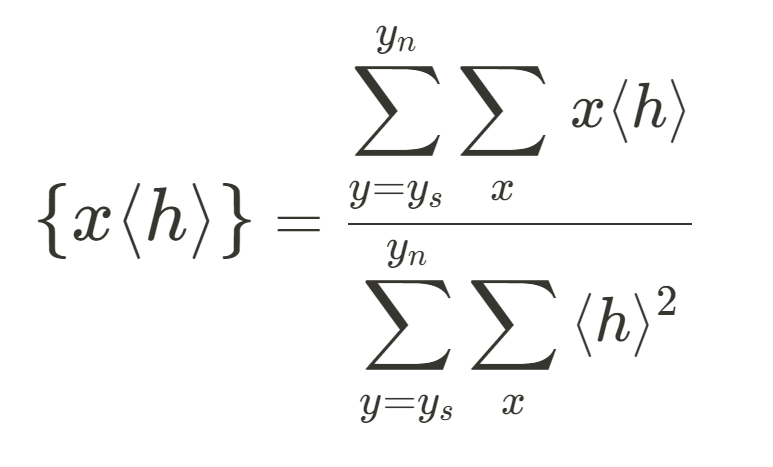
</p>

## Define budget calculation function

In [ ]:
def calculate_budget(field, column_MSE):
    budget = np.einsum(
        '...ji, ...ji -> ...',
        field,
        column_MSE
    ) / np.einsum(
        '...ji, ...ji -> ...',
        column_MSE,
        column_MSE
    )
    return budget

## Growth Budget

### Calculate growth budget

In [ ]:
south_bound = -30
north_bound = 30
south_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = output_column_temperature + output_column_moisture

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_growth_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
meridional_advection_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    output_meridional_gridpoints[None, south_lat_index:north_lat_index, None] 
    * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

# meridional_advection_growth_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
#     (
#         output_meridional_gridpoints 
#         * np.exp(-(meridional_gridpoints/3/length_scale)**2)
#     )[None, south_lat_index:north_lat_index , None]
#     * output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
#     column_MSE[:, south_lat_index:north_lat_index, :]
# )

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = 1j*zonal_wavenumber[None,:]*output_ux_fft
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = 1j*meridional_wavenumber[:,None]*output_vy_fft
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_growth_contribution = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        column_MSE[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
# column_convective_heating = (
#     + MOISTURE_SENSITIVITY*output_column_moisture
#     - TEMPERATURE_SENSITIVITY*output_column_temperature
# )

column_convective_heating = (
    + MOISTURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[None, :, None] * output_column_moisture
    - TEMPERATURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[None, :, None] * output_column_temperature
)

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_growth_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :], 
    column_MSE[:, south_lat_index:north_lat_index, :]
)

residual_MSE_growth = (
    vertical_advection_growth_contribution
    + zonal_advection_growth_contribution
    + meridional_advection_growth_contribution
    + column_radiative_heating_growth_contribution
)

growth_budget_dataset = xr.Dataset(
    data_vars = {
        'growth' : (['time'], residual_MSE_growth),
        'omega'  : (['time'], vertical_advection_growth_contribution),
        'u'      : (['time'], zonal_advection_growth_contribution),
        'v'      : (['time'], meridional_advection_growth_contribution),
        'Qr'     : (['time'], column_radiative_heating_growth_contribution),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

growth_budget_dataset.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_growth-budget.nc"
)
print('Growth budget saved')

### Plot at a single time

In [ ]:
# Specify the time at which to calculate/plot the budget
t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()

# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        3600*residual_MSE_growth[t],   
        3600*vertical_advection_growth_contribution[t], 
        3600*zonal_advection_growth_contribution[t], 
        3600*meridional_advection_growth_contribution[t], 
        3600*column_radiative_heating_growth_contribution[t]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# Plot the budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=10)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r'hr$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{specified_initial_condition_name}_"
#     + f"growth-budget_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

### Plot as a function of time

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(16.5, 6.4))

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    3600*residual_MSE_growth,   
    color=bar_colors[0],
    label=bar_labels[0],
    lw=3
)

plt.fill_between(
    downsampled_timepoints/SECONDS_PER_DAY,
    3600*vertical_advection_growth_contribution,
    label = bar_labels[1],
    color = bar_colors[1],
    alpha=1
)

plt.stackplot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    3600*zonal_advection_growth_contribution, 
    3600*meridional_advection_growth_contribution, 
    3600*column_radiative_heating_growth_contribution,
    labels = bar_labels[2:],
    colors= bar_colors[2:],
    alpha=1
)

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*vertical_advection_growth_contribution,
#     color=bar_colors[1],
#     label=bar_labels[1]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*zonal_advection_growth_contribution, 

#     color=bar_colors[2],
#     label=bar_labels[2]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*meridional_advection_growth_contribution, 

#     color=bar_colors[3],
#     label=bar_labels[3]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     3600*column_radiative_heating_growth_contribution,
#     color=bar_colors[4],
#     label=bar_labels[4]
# )

# plt.plot(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     3600*residual_MSE_growth,  
#     color='orange',
#     lw=4
# )

plt.axhline(y=0, color='#bcbcbc', ls='--', lw=3)
plt.legend(fontsize=14)
plt.xlim(10, 140)
plt.ylim(-0.02, 0.02)
plt.ylabel(r'hr$^{-1}$', labelpad=35, rotation=0, va='center')
plt.xlabel('Day')

plt.show()

### Animation

In [ ]:
starting_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 70).argmin()
ending_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()
frame_interval = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()

bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        3600*residual_MSE_growth[starting_frame],   
        3600*vertical_advection_growth_contribution[starting_frame], 
        3600*zonal_advection_growth_contribution[starting_frame], 
        3600*meridional_advection_growth_contribution[starting_frame], 
        3600*column_radiative_heating_growth_contribution[starting_frame]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))
ax.set_title(f"Growth budget, day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", pad=15)
ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
ax.set_ylabel(r'hr$^{-1}$', labelpad=20, rotation=0, va='center')
ax.set_ylim(-0.01, 0.01)

def update(t):
    
    bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
    bar_values =     [
            # 3600*MSE_tendency,
            3600*residual_MSE_growth[t],   
            3600*vertical_advection_growth_contribution[t], 
            3600*zonal_advection_growth_contribution[t], 
            3600*meridional_advection_growth_contribution[t], 
            3600*column_radiative_heating_growth_contribution[t]
        ]
    bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

    plt.cla()
    ax.set_title(f"Growth budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=15)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r'hr$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(-0.01, 0.01)

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_"
    + f"growth-budget_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
)


### Horizontal structure

In [ ]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
fig = plt.figure(figsize=(8.5, 11))
gs_main = gs.GridSpec(1, 2, width_ratios = [40,1], figure=fig)
gs_main.update(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.15)

gs_maps = gs.GridSpecFromSubplotSpec(2, 1, hspace=0.2, subplot_spec=gs_main[0])
gs_cbar = gs.GridSpecFromSubplotSpec(18, 1, subplot_spec=gs_main[1])

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_maps[0]))
ax.append(fig.add_subplot(gs_maps[1]))

cbar_ax = fig.add_subplot(gs_cbar[1:-1, :])

t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 30).argmin()

#### First plot
ax[0].set_title(r'(a) MSE, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

# meridional_advection_field = -MERIDIONAL_MOISTENING_PARAMETER*output_meridional_gridpoints[None, :, None]*output_meridional_velocity
meridional_advection_field = (
    (output_meridional_gridpoints*np.exp(-(output_meridional_gridpoints/3/length_scale)**2))[None, : , None]
    * output_meridional_velocity
)

CS_v = ax[0].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)

zonal_advection_field = ZONAL_MOISTENING_PARAMETER*output_zonal_velocity
CS_u = ax[0].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

# ax[0].set_xlim(-50, 150)
ax[0].set_ylim(-35, 35)
# ax[0].set_xticklabels(mjo.tick_labeller(np.arange(-180, 180, 30), 'lon'))
# ax[0].set_yticklabels(mjo.tick_labeller(np.arange(-50, 65, 15), 'lat'))
ax[0].set_aspect('auto')
cbar = plt.colorbar(CF_MSE, cax=cbar_ax, orientation='vertical')
cbar.set_label('K', rotation=0, va='center', labelpad=20)

#### Second Plot
ax[1].set_title(r'(b) MSE, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_MSE[t]/COLUMN_AVERAGE_MASS,
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

vertical_advection_field = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * vertical_velocity
)
CS_omega = ax[1].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)

# ax[1].set_xlim(-50, 150)
ax[1].set_ylim(-35, 35)
# ax[1].set_xticklabels(mjo.tick_labeller(np.arange(-180, 180, 30), 'lon'))
# ax[1].set_yticklabels(mjo.tick_labeller(np.arange(-50, 65, 15), 'lat'))
ax[1].set_aspect('auto')

plt.show()

## Propagation Budget

### Calculate propagation budget

In [ ]:
south_bound = -30
north_bound = 30
south_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - south_bound).argmin()
north_lat_index = np.abs(meridional_gridpoints/METERS_PER_DEGREE - north_bound).argmin()

# Calculate the column MSE : <h> = <T> + <q>
column_MSE = output_column_temperature + output_column_moisture

# Calculate the MSE tendency directly from the variable
MSE_tendency = np.gradient(column_MSE, downsampled_timepoints, axis=0)

# Calculate the contribution of zonal advection : σ_x {u_1 <h>}
zonal_advection_propagation_contribution = ZONAL_MOISTENING_PARAMETER*calculate_budget(
    output_zonal_velocity[:, south_lat_index:north_lat_index, :], 
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

# Calculate the contribution of meridional advection : -σ_y {y v_1 <h>}
# meridional_advection_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
#     meridional_gridpoints[south_lat_index:north_lat_index,None]*output_meridional_velocity[:, south_lat_index:north_lat_index, :], 
#     MSE_tendency[:, south_lat_index:north_lat_index, :]
# )

meridional_advection_propagation_contribution = -MERIDIONAL_MOISTENING_PARAMETER*calculate_budget(
    (meridional_gridpoints*np.exp(-(meridional_gridpoints/3/length_scale)**2))[:,None]*output_meridional_velocity, 
    column_MSE
)

### Compute the divergence of the velocity field to get vertical velocity
# dudx
output_ux_fft = fft(output_zonal_velocity, axis=2)
output_dudx_fft = 1j*zonal_wavenumber[None,:]*output_ux_fft
output_dudx = np.real(ifft(output_dudx_fft, axis=2))

# dvdy
output_vy_fft = fft(output_meridional_velocity, axis=1)
output_dvdy_fft = 1j*meridional_wavenumber[:,None]*output_vy_fft
output_dvdy = np.real(ifft(output_dvdy_fft, axis=1))

# ω = -(dudx + dvdy)
divergence = output_dudx + output_dvdy
vertical_velocity = -divergence

# Calculate the contribution of vertical advection : m M_s {ω_1 <h>}
vertical_advection_propagation_contribution = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * calculate_budget(
        vertical_velocity[:, south_lat_index:north_lat_index, :], 
        MSE_tendency[:, south_lat_index:north_lat_index, :]
    )
)

# Calculate column convective heating <Q_c> = ε_q<q> -ε_t<T> 
# column_convective_heating = (
#     + MOISTURE_SENSITIVITY*output_column_moisture
#     - TEMPERATURE_SENSITIVITY*output_column_temperature
# )

column_convective_heating = (
    + MOISTURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[:, None] * output_column_moisture
    - TEMPERATURE_SENSITIVITY * np.exp(-(output_meridional_gridpoints/length_scale)**2)[:, None] * output_column_temperature
)

# Calculate column radiative heating <Q_r> = r<Q_c>
column_radiative_heating = CLOUD_RADIATIVE_PARAMETER*column_convective_heating

# Calculate the contribution of column radiative heating : {<Q_r> <h>}
column_radiative_heating_propagation_contribution = calculate_budget(
    column_radiative_heating[:, south_lat_index:north_lat_index, :],
    MSE_tendency[:, south_lat_index:north_lat_index, :]
)

residual_MSE_propagation = (
    vertical_advection_propagation_contribution
    + zonal_advection_propagation_contribution
    + meridional_advection_propagation_contribution
    + column_radiative_heating_propagation_contribution
)

propagation_budget_dataset = xr.Dataset(
    data_vars = {
        'propagation' : (['time'], residual_MSE_propagation),
        'omega'  : (['time'], vertical_advection_propagation_contribution),
        'u'      : (['time'], zonal_advection_propagation_contribution),
        'v'      : (['time'], meridional_advection_propagation_contribution),
        'Qr'     : (['time'], column_radiative_heating_propagation_contribution),
    },
    coords = {
        'time' : downsampled_timepoints
    },
    attrs= {
        'Latitude Bounds' : (south_bound, north_bound),
        'Initial Wavenumber' : output_wavenumber*EARTH_RADIUS
    }
)

propagation_budget_dataset.to_netcdf(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_propagation-budget.nc"
)
print('Propagation budget saved')

### Plot at a single time

In [ ]:
# Specify the time at which to calculate/plot the propagation_contribution
t = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 80).argmin()

# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        residual_MSE_propagation[t],   
        vertical_advection_propagation_contribution[t], 
        zonal_advection_propagation_contribution[t], 
        meridional_advection_propagation_contribution[t], 
        column_radiative_heating_propagation_contribution[t]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

# Plot the propagation budgets
plt.style.use('default')
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(16.5, 6.4))
plt.title(f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=10)
plt.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
plt.axhline(y=0, color='gray', lw=3, alpha=0.75)
plt.ylabel(r's$^{-1}$', labelpad=35, rotation=0, va='center')
plt.show()
# plt.savefig(
#       f"{specified_output_file_directory}/{specified_initial_condition_name}_"
#     + f"propagation-budget_{downsampled_timepoints[t]/SECONDS_PER_DAY:0.1f}-days_{time.strftime('%Y%m%d-%H%M')}.png", 
#     bbox_inches='tight'
# )

### Plot as a function of time

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(16.5, 6.4))

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    residual_MSE_propagation,   
    color=bar_colors[0],
    label='Propagation',
    lw=3
)

# plt.fill_between(
#     downsampled_timepoints/SECONDS_PER_DAY,
#     vertical_advection_propagation_contribution,
#     label = bar_labels[1],
#     color = bar_colors[1],
#     alpha=1
# )

# plt.stackplot(
#     downsampled_timepoints/SECONDS_PER_DAY, 
#     zonal_advection_propagation_contribution, 
#     meridional_advection_propagation_contribution, 
#     column_radiative_heating_propagation_contribution,
#     labels = bar_labels[2:],
#     colors= bar_colors[2:],
#     alpha=1
# )

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    vertical_advection_propagation_contribution,
    color=bar_colors[1],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    zonal_advection_propagation_contribution, 

    color=bar_colors[2],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    meridional_advection_propagation_contribution, 

    color=bar_colors[3],
)

plt.plot(
    downsampled_timepoints/SECONDS_PER_DAY, 
    column_radiative_heating_propagation_contribution,
    color=bar_colors[4],
)

plt.axhline(y=0, color='#bcbcbc', ls='--', lw=3)
plt.legend(fontsize=14)
plt.xlim(10, 180)
# plt.ylim(-0.02, 0.02)
plt.ylabel(r's$^{-1}$', labelpad=35, rotation=0, va='center')
plt.xlabel('Day')

plt.show()

### Animation

In [ ]:
starting_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 10).argmin()
ending_frame = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 130).argmin()
frame_interval = np.abs(downsampled_timepoints/SECONDS_PER_DAY - 1).argmin()


# Label the bars 
bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_values =     [
        # 3600*MSE_tendency,
        residual_MSE_propagation[starting_frame],   
        vertical_advection_propagation_contribution[starting_frame], 
        zonal_advection_propagation_contribution[starting_frame], 
        meridional_advection_propagation_contribution[starting_frame], 
        column_radiative_heating_propagation_contribution[starting_frame]
    ]
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']


[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.4))
ax.set_title(f"Propagation budget, day {downsampled_timepoints[starting_frame]/SECONDS_PER_DAY :0.1f}", pad=15)
ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
ax.set_ylabel(r's$^{-1}$', labelpad=20, rotation=0, va='center')
ax.set_ylim(-1, 1)

def update(t):
    
    bar_labels = [r'Propagation', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
    bar_values =     [
            # 3600*MSE_tendency,
            residual_MSE_propagation[t],   
            vertical_advection_propagation_contribution[t], 
            zonal_advection_propagation_contribution[t], 
            meridional_advection_propagation_contribution[t], 
            column_radiative_heating_propagation_contribution[t]
        ]
    bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

    plt.cla()
    ax.set_title(f"Propagation budget, day {downsampled_timepoints[t]/SECONDS_PER_DAY :0.1f}", pad=15)
    ax.bar(bar_labels, bar_values, color=bar_colors, edgecolor='gray', linewidth=3)
    ax.axhline(y=0, color='gray', lw=3, alpha=0.75)
    ax.set_ylabel(r's$^{-1}$', labelpad=20, rotation=0, va='center')
    ax.set_ylim(-1, 1)

# Run the animation
anim = FuncAnimation(
    fig, 
    update, 
    frames=tqdm(
        np.arange(starting_frame, ending_frame, frame_interval), 
        ncols=100, 
        position=0, 
        leave=True
    ), interval=300
)

anim.save(
    f"{specified_output_file_directory}/{specified_initial_condition_name}_"
    + f"propagation-budget_animation_{time.strftime('%Y%m%d-%H%M')}.mp4", 
    dpi=300
    )


### Horizontal structure

In [ ]:
fig = plt.figure(figsize=(11, 8.5))
gs_main = gs.GridSpec(2, 2, width_ratios = [40,1], figure=fig)
gs_main.update(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.2)

ax = []
# Add an axis for the initial condition
ax.append(fig.add_subplot(gs_main[0, 0]))
ax.append(fig.add_subplot(gs_main[1 ,0]))

cbar_ax = fig.add_subplot(gs_main[:, 1])

#### First plot
ax[0].set_title(r'$\frac{dMSE}{dt}$, -σ$_y$yv$_1$, and σ$_x$u$_1$')
CF_MSE = ax[0].contourf(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t],
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)


meridional_advection_field = -MERIDIONAL_MOISTENING_PARAMETER*meridional_gridpoints[:,None]*output_meridional_velocity
CS_v = ax[0].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    meridional_advection_field[t],
    colors=bar_colors[3],
    levels=np.delete(np.linspace(np.min(meridional_advection_field[t]), np.max(meridional_advection_field[t]), 11), [5])
)

zonal_advection_field = ZONAL_MOISTENING_PARAMETER*output_zonal_velocity
CS_u = ax[0].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    zonal_advection_field[t],
    colors=bar_colors[2],
    levels=np.delete(np.linspace(np.min(zonal_advection_field[t]), np.max(zonal_advection_field[t]), 11), [5])
)

ax[0].set_ylim(-35, 35)
# ax[0].set_xlim(-50, 150)
ax[0].set_aspect('equal')
plt.colorbar(CF_MSE, cax=cbar_ax, orientation='vertical')

#### Second Plot
ax[1].set_title(r'$\frac{dMSE}{dt}$, $\langle$Q$_r$$\rangle$, and ω$_1$mM$_s$')
ax[1].contourf(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    MSE_tendency[t],
    cmap=Ahmed_cmap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21,
    # alpha=0.75
)

CS_Qr = ax[1].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    column_radiative_heating[t],
    colors=bar_colors[4],
    levels=np.delete(np.linspace(np.min(column_radiative_heating[t]), np.max(column_radiative_heating[t]), 11), [5])
)

vertical_advection_field = (
    (GROSS_DRY_STABILITY - gross_moisture_stratification)/GROSS_DRY_STABILITY
    * GROSS_DRY_STABILITY
    * vertical_velocity
)
CS_omega = ax[1].contour(
    zonal_gridpoints/METERS_PER_DEGREE,
    meridional_gridpoints/METERS_PER_DEGREE,
    vertical_advection_field[t],
    colors=bar_colors[1],
    levels=np.delete(np.linspace(np.min(vertical_advection_field[t]), np.max(vertical_advection_field[t]), 11), [5])
)

ax[1].set_ylim(-35, 35)
# ax[1].set_xlim(-50, 150)
ax[1].set_aspect('equal')
plt.show()

# Load data metrics

In [ ]:
experiment_to_load = specified_output_file_directory
initial_conditions_to_load = [f"k=1.0_m=1_Kelvin-wave", f"k=2.0_m=1_Kelvin-wave", f"k=3.0_m=1_Kelvin-wave", f"k=4.0_m=1_Kelvin-wave"]

phase_speeds = {}
growth_budgets = {}
propagation_budgets = {}
for ic in initial_conditions_to_load:
    phase_speeds[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_instantaneous-phase-speed.nc")['phase speed']
    growth_budgets[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_growth-budget.nc")
    propagation_budgets[ic] = xr.load_dataset(f"{specified_output_file_directory}/{ic}_propagation-budget.nc")

print("Data loaded")

In [ ]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

t = np.abs(phase_speeds[exp]['time']/SECONDS_PER_DAY - 30).argmin()

width = 0.15
multiplier = 0
x = np.arange(len(bar_labels))

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for exp in growth_budgets:
    offset = width * multiplier
    bar_values = [
            3600*growth_budgets[exp]['growth'][t],
            3600*growth_budgets[exp]['omega'][t],
            3600*growth_budgets[exp]['u'][t],
            3600*growth_budgets[exp]['v'][t],
            3600*growth_budgets[exp]['Qr'][t]
        ]
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

    for l in range(len(bar_labels)):
        ax.text(l, 0.0105, s=bar_labels[l])# bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round, pad=0.25'))

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(f"Growth Budget, Day {growth_budgets[exp]['time'][t]/SECONDS_PER_DAY:0.1f}", pad=50) 
ax.set_ylim(-0.01, 0.01)
ax.set_xticks(
    np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
ax.set_ylabel(r'hr$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()

In [ ]:
# Label the bars 
bar_labels = [r'Growth', r'ω$_1$mM$_s$', r'σ$_x$u$_1$', r'-σ$_y$yv$_1$', r'$\langle$Q$_r$$\rangle$']
bar_colors = ['#ffa500', '#1cf91a', '#0533ff', '#ff40ff', '#4e2d8c']

t = np.abs(phase_speeds[exp]['time']/SECONDS_PER_DAY - 30).argmin()

width = 0.15
multiplier = 0
x = np.arange(len(bar_labels))

y_max = 2.25

plt.style.use('default')
plt.rcParams.update({'font.size':18})
[fig, ax] = plt.subplots(1, 1, figsize=(16.5, 6.5))
for exp in propagation_budgets:
    offset = width * multiplier
    bar_values = [
            propagation_budgets[exp]['propagation'][t],
            propagation_budgets[exp]['omega'][t],
            propagation_budgets[exp]['u'][t],
            propagation_budgets[exp]['v'][t],
            propagation_budgets[exp]['Qr'][t]
        ]
    rects = ax.bar(
        x + offset, 
        bar_values, 
        label = exp, 
        color = bar_colors, 
        width = width,
        edgecolor='gray', 
        linewidth=3,
        align='center'
    )    
    # ax.bar_label(rects, padding=0.3)
    multiplier += 1

    for l in range(len(bar_labels)):
        ax.text(l, y_max + 0.105, s=bar_labels[l])# bbox=dict(facecolor='#eeeeee', edgecolor='#bcbcbc', boxstyle='round, pad=0.25'))

ax.axhline(y = 0, color='gray', lw=2)

ax.set_title(f"Propagation Budget, Day {propagation_budgets[exp]['time'][t]/SECONDS_PER_DAY:0.1f}", pad=50) 
ax.set_ylim(-1.0, y_max)
# ax.set_xticks(np.append(x, x+offset), np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
ax.set_xticks(
    np.concatenate((x, x+offset/3, x+2*offset/3, x+offset)),
    sorted(np.arange(len(bar_labels)*len(initial_conditions_to_load))%len(initial_conditions_to_load)+1)
)
ax.set_ylabel(r's$^{-1}$', rotation=0, labelpad=20)
ax.set_xlabel('Zonal Wavenumber', labelpad=10)
# ax.legend()
plt.show()

# Auxiliary functions

In [ ]:
damp_lat = 30
damp_width = 10
damp_strength = 1
t_index = 0
fringe_region_damping = fringe_region_damping_function(-damp_lat, damp_lat, damp_width, damp_strength)

plt.style.use('bmh')
plt.figure(figsize=(16,4))
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    output_zonal_velocity[t_index, :, 15]
)
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    fringe_region_damping,
    ls='--', color='k', lw=1
)

plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    fringe_region_damping*output_zonal_velocity[t_index, :, 15],
    color=bmh_colors('red')
)
plt.plot(
    meridional_gridpoints/METERS_PER_DEGREE, 
    (1-fringe_region_damping)*output_zonal_velocity[t_index, :, 15], 
    color=bmh_colors('green')
)

plt.axvline(x=damp_lat, color='k', ls=':')
plt.axvline(x=-damp_lat, color='k', ls=':')

plt.axvline(x=damp_lat-damp_width, color='k', ls=':')
plt.axvline(x=-damp_lat+damp_width, color='k', ls=':')

plt.show()

## Zonally varying σ_x function

In [ ]:
def zonally_varying_sigma_x_function(
    western_edge=-30, 
    eastern_edge=30, 
    half_width=15
):
    
    sigma_x = np.zeros_like((zonal_gridpoints))
    width = 2*half_width*METERS_PER_DEGREE/EARTH_RADIUS
    non_dimensional_zonal_coordinate = zonal_gridpoints/EARTH_RADIUS
    
    west_region_indices = np.where((zonal_gridpoints/METERS_PER_DEGREE <= western_edge))[0]
    central_region_indices = np.where(
        (zonal_gridpoints/METERS_PER_DEGREE > western_edge)*(zonal_gridpoints/METERS_PER_DEGREE < eastern_edge)
    )[0]
    east_region_indices = np.where((zonal_gridpoints/METERS_PER_DEGREE >= eastern_edge))[0]
    
    sigma_x[west_region_indices] = np.exp(
        -(non_dimensional_zonal_coordinate[west_region_indices]-western_edge*METERS_PER_DEGREE/EARTH_RADIUS)**2/width**2
    )
    sigma_x[central_region_indices] = 1
    sigma_x[east_region_indices] = np.exp(
        -(non_dimensional_zonal_coordinate[east_region_indices]-eastern_edge*METERS_PER_DEGREE/EARTH_RADIUS)**2/width**2
    )
    sigma_x[sigma_x < 1e-6] = 0

    if np.min(sigma_x) > 0:
        raise ValueError('Half-width too large')

    return sigma_x

# Filtered Solutions

In [ ]:
cutoff_days = 20

low_u = mjo.butter_lowpass_filter(zonal_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_v = mjo.butter_lowpass_filter(meridional_velocity.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_T = mjo.butter_lowpass_filter(column_temperature.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T
low_q = mjo.butter_lowpass_filter(column_moisture.T, 1/(cutoff_days*SECONDS_PER_DAY), 1/time_step).T

In [ ]:
# phase_speed = np.einsum('i,j->ikj', zonal_wavenumber, frequencies)
frequencies = np.fft.fftfreq(len(time_points), 1/time_step)
phase_speed = -np.repeat(np.einsum('i,j->ji', zonal_wavenumber, frequencies)[:, np.newaxis,:], len(meridional_gridpoints), axis=1)

u_fft = np.fft.fft2(low_u, axes=[0,2])
u_fft[np.where(phase_speed<=0)] = 0
u_east = np.real(np.fft.ifft2(u_fft, axes=[0,2]))

v_fft = np.fft.fft2(low_v, axes=[0,2])
v_fft[np.where(phase_speed<=0)] = 0
v_east = np.real(np.fft.ifft2(v_fft, axes=[0,2]))

T_fft = np.fft.fft2(low_T, axes=[0,2])
T_fft[np.where(phase_speed<=0)] = 0
T_east = np.real(np.fft.ifft2(T_fft, axes=[0,2]))

q_fft = np.fft.fft2(low_q, axes=[0,2])
q_fft[np.where(phase_speed<=0)] = 0
q_east = np.real(np.fft.ifft2(q_fft, axes=[0,2]))
# plt.contourf(np.real(test)[0,:,:], cmap='coolwarm', norm=mcolors.CenteredNorm())

In [ ]:
# # q_fft = np.fft.fft2(low_q, axes=[0,2])
# mask = np.zeros_like(low_u)
# mask[:,:,10] = 1

# u_fft = np.fft.fft2(low_u, axes=[0,2])
# u_fft_masked = u_fft*mask
# u_1 = np.real(np.fft.ifft2(u_fft_masked, axes=[0,2]))

# v_fft = np.fft.fft2(low_v, axes=[0,2])
# v_fft_masked = v_fft*mask
# v_1 = np.real(np.fft.ifft2(v_fft_masked, axes=[0,2]))

# T_fft = np.fft.fft2(low_T, axes=[0,2])
# T_fft_masked = T_fft*mask
# T_1 = np.real(np.fft.ifft2(T_fft_masked, axes=[0,2]))

# q_fft = np.fft.fft2(low_q, axes=[0,2])
# q_fft_masked = q_fft*mask
# q_1 = np.real(np.fft.ifft2(q_fft_masked, axes=[0,2]))